In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import iglob

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Setup

## Plotting Options

In [19]:
sns.set_palette("pastel")

In [20]:
mpl.rcParams['figure.figsize'] = (20, 20)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Computer Modern"
plt.rcParams["font.size"] = "24"

In [21]:
def cm_from_df(ax, df, name=None):
    cm = np.zeros((2,2), dtype=np.int32)
    cm[0][0] = df.tn.mean()
    cm[0][1] = df.fp.mean()
    cm[1][0] = df.fn.mean()
    cm[1][1] = df.tp.mean()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_title('{}'.format(name))
    ax.set(xlabel='Predicted label', ylabel='Actual label')

## Data Loaders

In [22]:
def load_final(experiment, verbose=False):
    pth = '../experiments/*/{}/*/*_test_final.pkl'.format(experiment)
    print("looking for {}".format(pth))
    pkls = [p for p in iglob(pth)]
    print("loading {} pkls".format(len(pkls)))
    dfs = []
    for p in pkls:
        if verbose:
            print(p)
        expid = p.split('/')[-2].split('_')[3]
        if verbose:
            print(expid)
        expid = int(expid)
        _df = pd.read_pickle(p)
        _df['experiment_id'] = expid
        dfs.append(_df)
    df = pd.concat(dfs, ignore_index=True)
    # ignore 0.000 threshold
    df = df[~df['threshold'].isin([0.0])]
    return df

In [23]:
try:
   import cPickle as pickle
except:
   import pickle

EPILSON = 1e-07


def load_results(experiment):
    experiments = []
    pth = '../experiments/*/{}/*/experiment.pkl'.format(experiment)
    print("looking for {}".format(pth))
    for pkl_path in iglob(pth):
        with open(pkl_path, 'rb') as f:
            experiments.append(pickle.loads(f.read()))
    print("loading {} pkls".format(len(experiments)))

    cols = ['dataset', 'loss', 'split', 'metric', 'value']
    df_dict = {}
    for col in cols:
        df_dict[col] = []
    for experiment in experiments:
        for dataset_name in experiment['results'].keys():
            for loss in experiment['results'][dataset_name].keys():
                for split in experiment['results'][dataset_name][loss].keys():
                    for metric in experiment['results'][dataset_name][loss][split].keys():
                        df_dict['loss'].append(loss)
                        df_dict['dataset'].append(dataset_name)
                        df_dict['split'].append(split)
                        df_dict['metric'].append(metric)
                        df_dict['value'].append(experiment['results'][dataset_name][loss][split][metric])

                    tp = experiment['results'][dataset_name][loss][split]['tp']
                    fp = experiment['results'][dataset_name][loss][split]['fp']
                    tn = experiment['results'][dataset_name][loss][split]['tn']
                    df_dict['loss'].append(loss)
                    df_dict['dataset'].append(dataset_name)
                    df_dict['split'].append(split)
                    df_dict['metric'].append('tpr')
                    df_dict['value'].append(tp/(tp+fp+EPILSON))
                    df_dict['loss'].append(loss)
                    df_dict['dataset'].append(dataset_name)
                    df_dict['split'].append(split)
                    df_dict['metric'].append('fpr')
                    df_dict['value'].append(tp/(tp+tn+EPILSON))
    return pd.DataFrame.from_dict(df_dict)

## Approximations

### Naive Sigmoid

In [24]:
def sigmoid_heaviside(k=1):
    '''
        Simple sigmoid
            - limits do not necessarily converge to the heaviside function
            - derivative can be 0
        = a/(1+e^(-k*(x+threshold)))
        for simplicity: a == 1
    '''
    def f(xs_thresholds):
        x, ti = xs_thresholds
        x = x - ti
        return 1/(1+tf.exp(-k*x))
    return f


### Fit Sigmoid

In [25]:
import math

import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
if not len(gpu_devices):
    raise RuntimeError("no GPU in: {}".format(gpu_devices))
for gpu in gpu_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op

from tensorflow.python.keras import backend_config
epsilon = backend_config.epsilon

def threshold_input_to_threshold_param(x, w=math.pi, o=math.pi/2):
    return -1 * tf.math.tan(x*w-o) + 0.5

def lin(x, m, b):
    return m*x+b

def threshold_param_to_weight(x, neg_w_b=[-20.00448894, 23.74890989], pos_w_b=[20.00475821, 3.7403742]):
    ''' There is a linear mapping between these params'''
    return tf.where(x < 0.5, lin(x, *neg_w_b), lin(x, *pos_w_b))

def fit_sigmoid_heaviside(xs_thresholds):
    '''
        http://jpeg:9998/notebooks/notebooks/Activation%20Function%20Plots.ipynb#Continuous-Functions
    '''
    x, ti = xs_thresholds
    t = threshold_input_to_threshold_param(ti)
    weight = threshold_param_to_weight(t)
    multiplier = 10
    s=1/(1+tf.math.exp(-x*weight+weight/2+(multiplier * (0.5-t))))
    return s

def heaviside_approx(xs_thresholds, delta=0.1):
    ''' piecewise linear approximation of the heaviside function
        x_and_t: x values over a given threshold
    '''
    x, t = xs_thresholds
    d = delta
    tt = tf.minimum(tf.abs(t), tf.abs(1-t))
    m1 = d/(t-tt/2)
    m2 = (1-2*d)/tt
    m3 = d/(1-t-tt/2)
    return tf.where(x < t - tt/2, m1*x,
        tf.where(x > t + tt/2, m3*x + (1-d-m3*(t+tt/2)),
            m2*(x-t)+0.5))

def l_tp(gt, pt, thresh):
    #assert gt.shape == pt.shape
    # output closer to 1 if a true positive, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 1 -> (inverter = 1)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (inverter = 1)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    gt_t = tf.reshape(tf.repeat(gt, thresh.shape[0]), (-1, thresh.shape[0]))
    pt_t = tf.reshape(tf.repeat(pt, thresh.shape[0]), (-1, thresh.shape[0]))
    condition = (gt_t == 0) & (pt_t >= thresh)
    xs = tf.where(condition, 1-pt_t, pt_t)
    thresholds = tf.where(condition, 1-thresh, thresh)
    return tf.reduce_sum(tf.vectorized_map(heaviside_approx, (xs, thresholds)), axis=0)


def l_fn(gt, pt, thresh):
    #assert gt.shape == pt.shape
    # output closer to 1 if a false negative, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  fn: (gt == 1 and pt == 0) -> closer to 1 -> (inverter = -1)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    gt_t = tf.reshape(tf.repeat(gt, thresh.shape[0]), (-1, thresh.shape[0]))
    pt_t = tf.reshape(tf.repeat(pt, thresh.shape[0]), (-1, thresh.shape[0]))
    condition = (gt_t == 0) & (pt_t < thresh)
    xs = tf.where(condition, pt_t, 1-pt_t)
    thresholds = tf.where(condition, thresh, 1-thresh)
    return tf.reduce_sum(tf.vectorized_map(heaviside_approx, (xs, thresholds)), axis=0)

def l_fp(gt, pt, thresh):
    #assert gt.shape == pt.shape
    # output closer to 1 if a false positive, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (inverter = 1)
    #  fp: (gt == 0 and pt == 1) -> closer to 1 -> (inverter = 1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    gt_t = tf.reshape(tf.repeat(gt, thresh.shape[0]), (-1, thresh.shape[0]))
    pt_t = tf.reshape(tf.repeat(pt, thresh.shape[0]), (-1, thresh.shape[0]))
    condition = (gt_t == 1) & (pt_t >= thresh)
    xs = tf.where(condition, 1-pt_t, pt_t)
    thresholds = tf.where(condition, 1-thresh, thresh)
    return tf.reduce_sum(tf.vectorized_map(heaviside_approx, (xs, thresholds)), axis=0)

def l_tn(gt, pt, thresh):
    #assert gt.shape == pt.shape
    # output closer to 1 if a true negative, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (invert = true)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (invert = false)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (invert = true)
    #  tn: (gt == 0 and pt == 0) -> closer to 1 -> (invert = true)
    gt_t = tf.reshape(tf.repeat(gt, thresh.shape[0]), (-1, thresh.shape[0]))
    pt_t = tf.reshape(tf.repeat(pt, thresh.shape[0]), (-1, thresh.shape[0]))
    condition = (gt_t == 1) & (pt_t < thresh)
    xs = tf.where(condition, pt_t, 1-pt_t)
    thresholds = tf.where(condition, thresh, 1-thresh)
    return tf.reduce_sum(tf.vectorized_map(heaviside_approx, (xs, thresholds)), axis=0)

def tf_confusion(gt, pt, thresholds):
    # 'tp', 'fn', 'fp', 'tn'
    tp = l_tp(gt, pt, thresholds)
    fn = l_fn(gt, pt, thresholds)
    fp = l_fp(gt, pt, thresholds)
    tn = l_tn(gt, pt, thresholds)
    return tp, fn, fp, tn

def f1(gt, pt):
    with tf.name_scope("F1Score"):
        #thresholds = tf.range(0.1, 1, 0.1)
        thresholds = tf.constant([0.5])
        tp, fn, fp, _ = tf_confusion(gt, pt, thresholds)
        precision = tp/(tp+fp+epsilon)
        recall = tp/(tp+fn+epsilon)
        f1 = tf.reduce_mean(2 * (precision * recall) / (precision + recall + K.epsilon()))
        return 1 - f1

In [26]:
import pathlib
pathlib.Path('plots').mkdir(exist_ok=True)

## Plot setup

In [27]:
LINEWIDTH=18
POINTSIZE=1600
LABELSIZE=75

### Heaviside

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


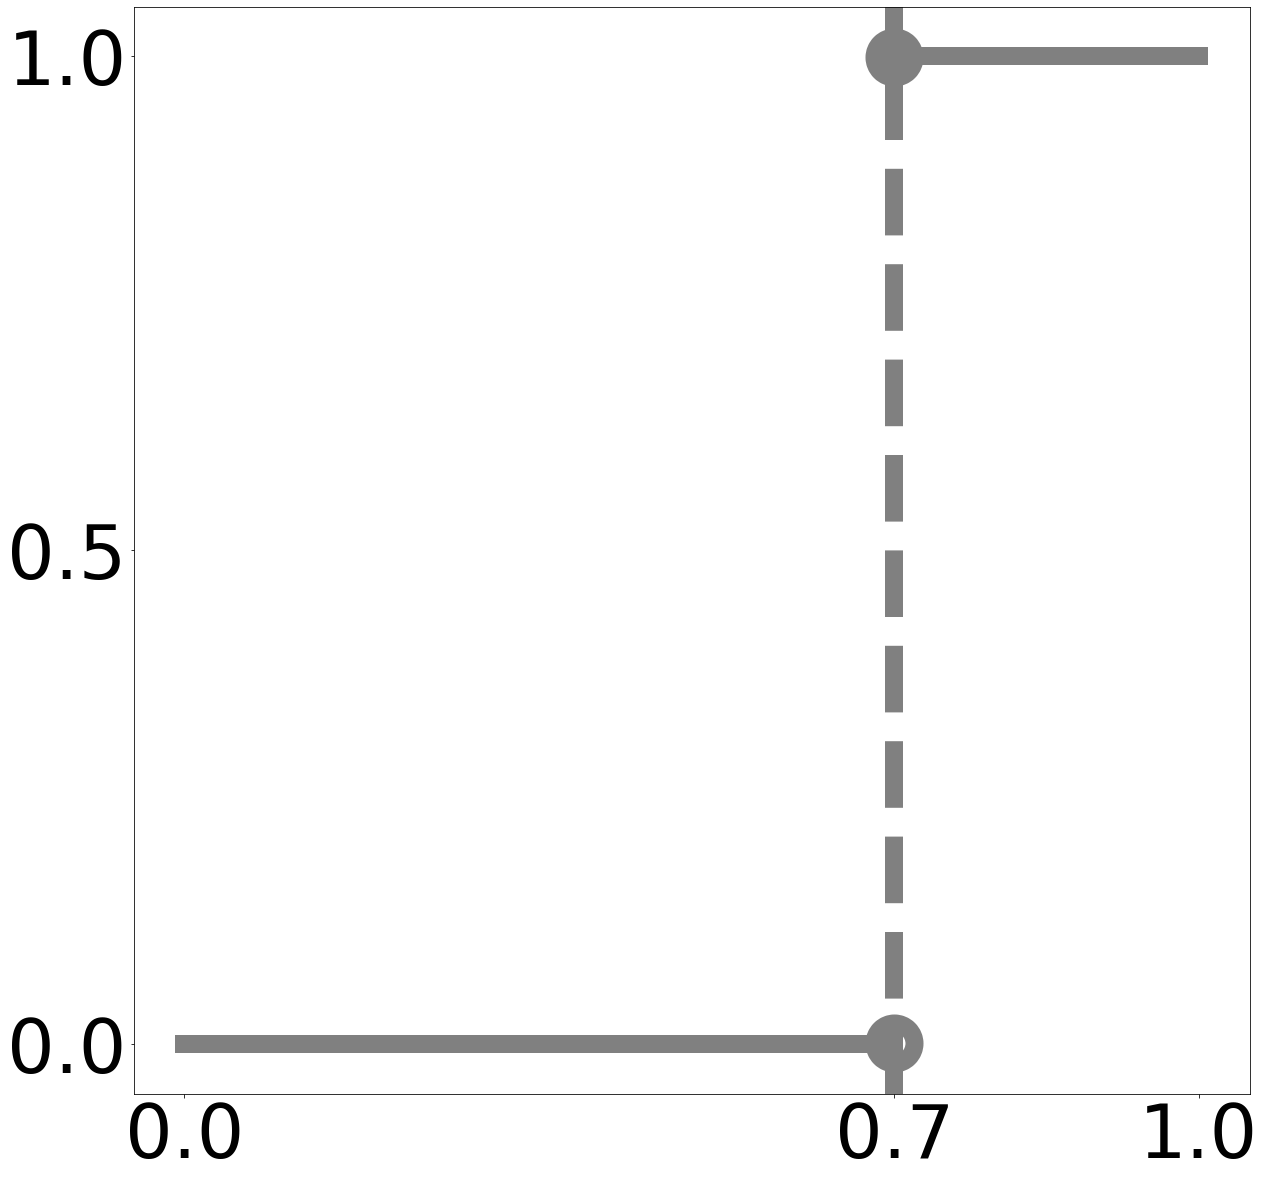

In [28]:
def H(x, t=0.5):
    return np.where(x < t, 0, 1)
t = 0.7
x = np.arange(0, t, 0.01)
x2 = np.arange(t, 1, 0.01)

plt.plot(x, H(x, t), linewidth=LINEWIDTH, c='grey')
plt.plot(x2, H(x2, t), linewidth=LINEWIDTH, c='grey')
plt.scatter([0.7], [0.001], facecolors='white', edgecolors='grey', linewidth=LINEWIDTH, s=POINTSIZE)
plt.scatter([0.7], [0.999], facecolors='grey', edgecolors='grey', linewidth=LINEWIDTH, s=POINTSIZE)
plt.axvline([0.7], color='grey', linestyle='--', linewidth=LINEWIDTH)

plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)

plt.xticks([0, 0.7, 1.0])
plt.yticks([0, 0.5, 1.0])

#plt.scatter(x, H(1-x, 1-t), linewidth=24, linestyle="--", alpha=0.95)
plt.savefig('plots/heaviside.pdf')
plt.show()

### Naive Sigmoid

K: 10, Threshold: 0.7


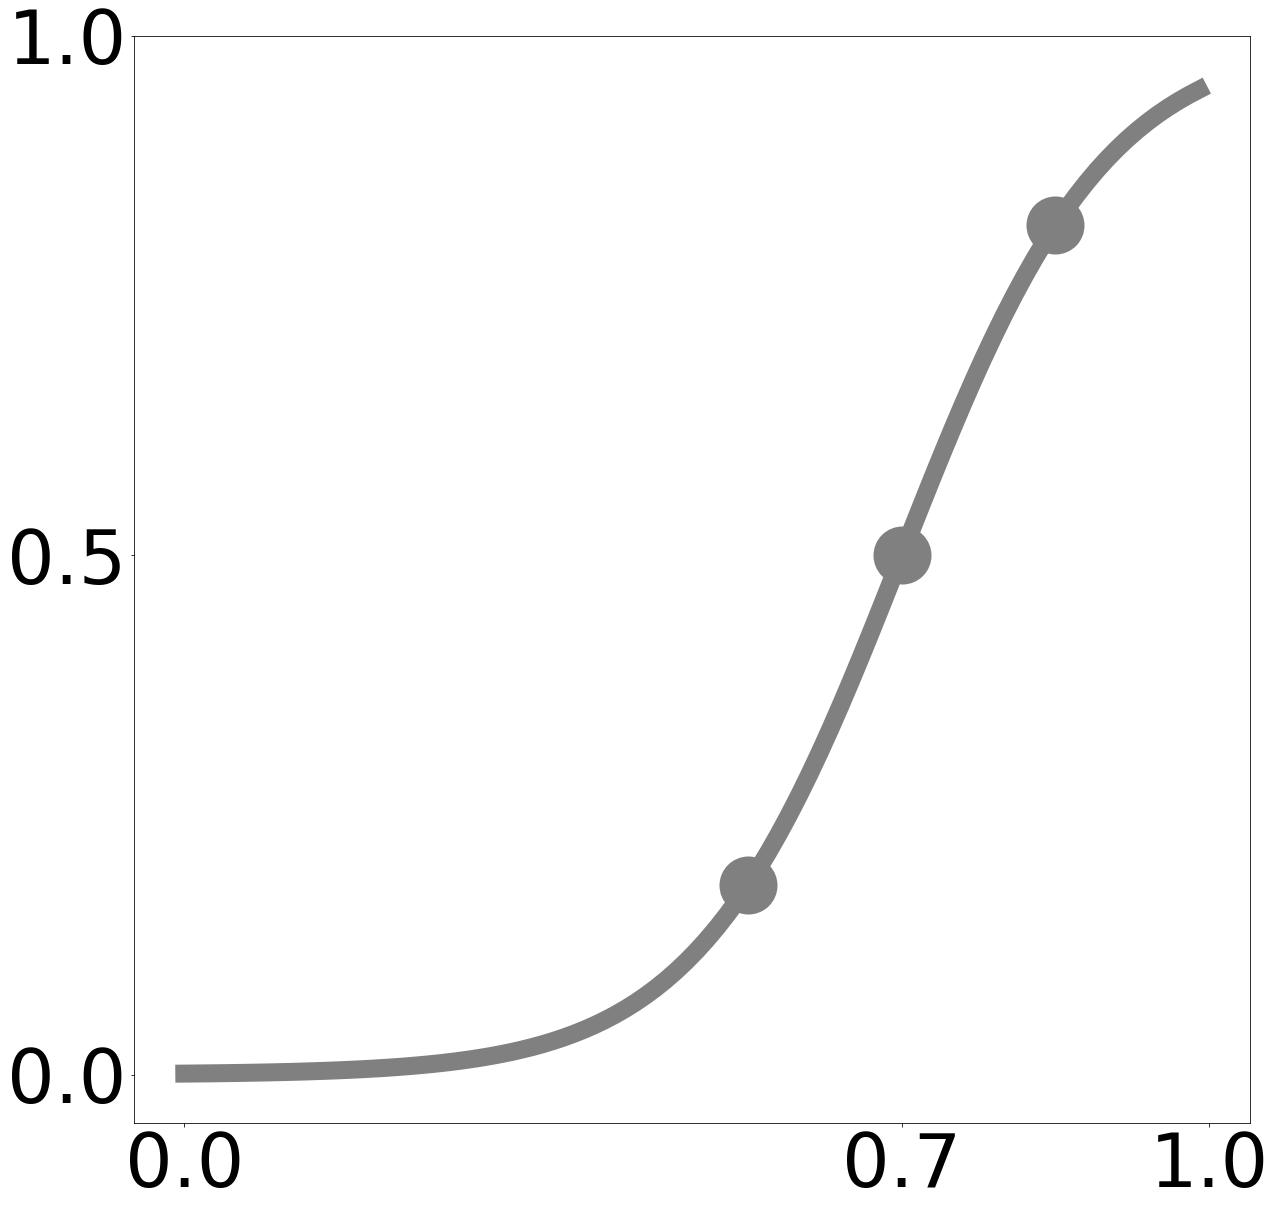

K: 20, Threshold: 0.7


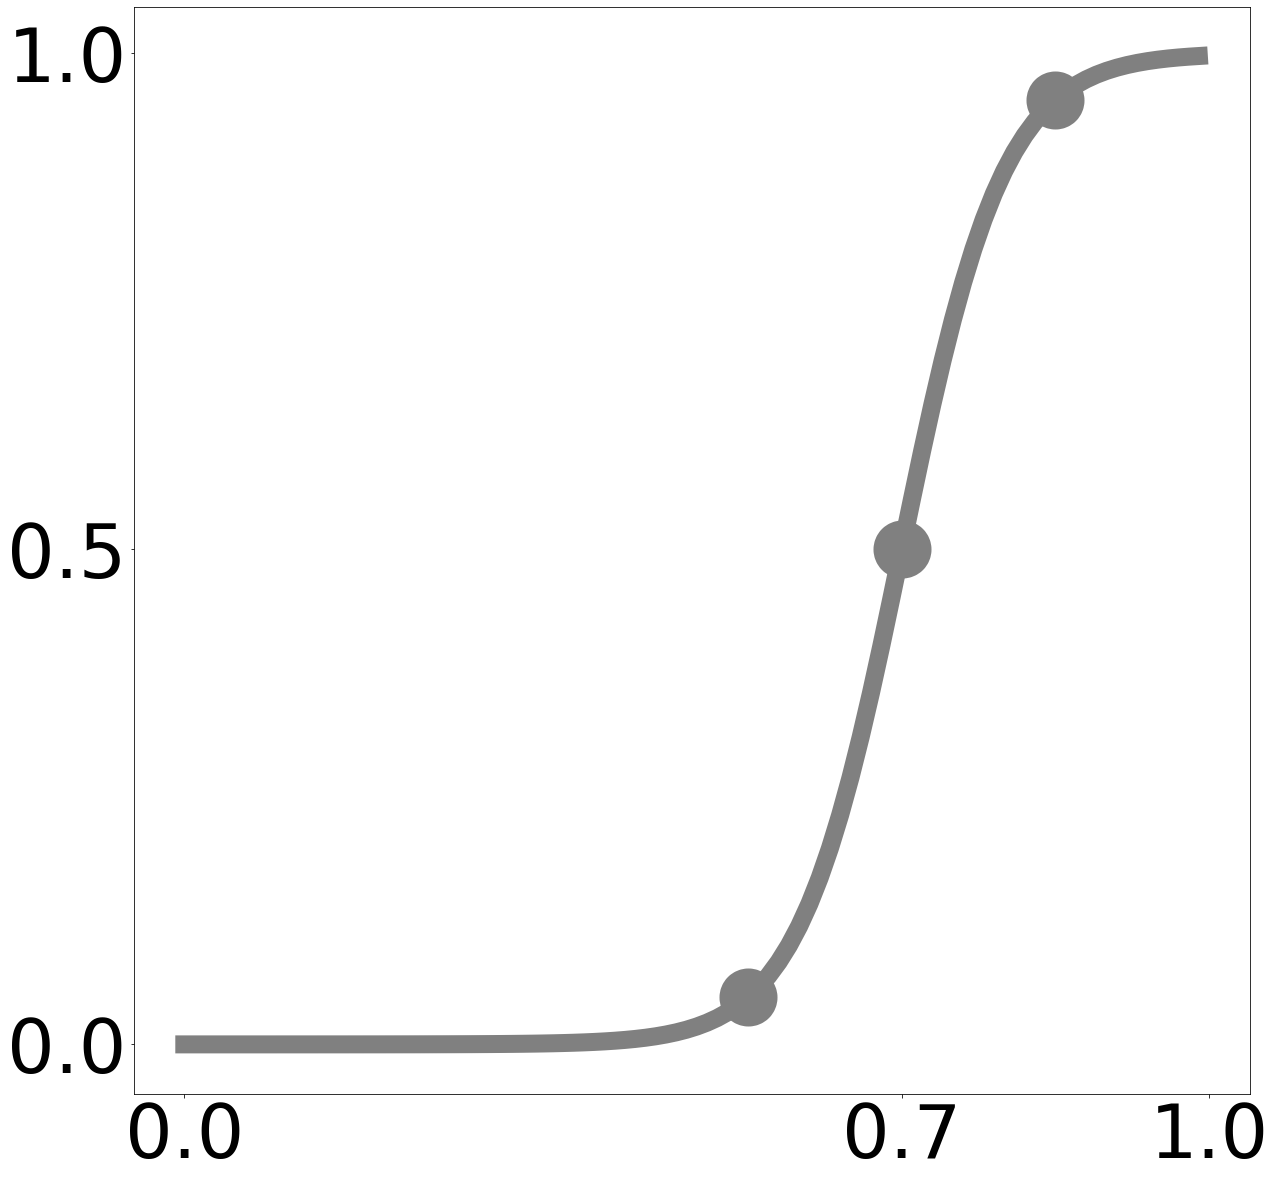

In [29]:
for k in [10, 20]:
    F = sigmoid_heaviside(k=k)

    thresholds = [0.7]
    l=0.15

    for thresh in thresholds:
        x = np.arange(0, 1, 0.01)
        plt.plot(x, F((x, thresh)), linewidth=LINEWIDTH, c='grey')
        xp = [thresh-l, thresh, thresh+l]
        yp = [F((thresh-l,thresh)).numpy(), F((thresh,thresh)).numpy(), F((thresh+l, thresh)).numpy()]
        print("K: {}, Threshold: {}".format(k,thresh))
        plt.scatter(xp, yp, facecolors='grey', edgecolors='grey', linewidth=LINEWIDTH, s=POINTSIZE)
        plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)
        plt.xticks([0, thresh, 1.0])
        plt.yticks([0, 0.5, 1.0])
        #plt.xlim(0,1)
        #plt.ylim(0,1)
        #plt.savefig('plots/heaviside_sigmoid_approx_{}.eps'.format(thresh))
        plt.show()

### Heaviside Sigmoid Approximation

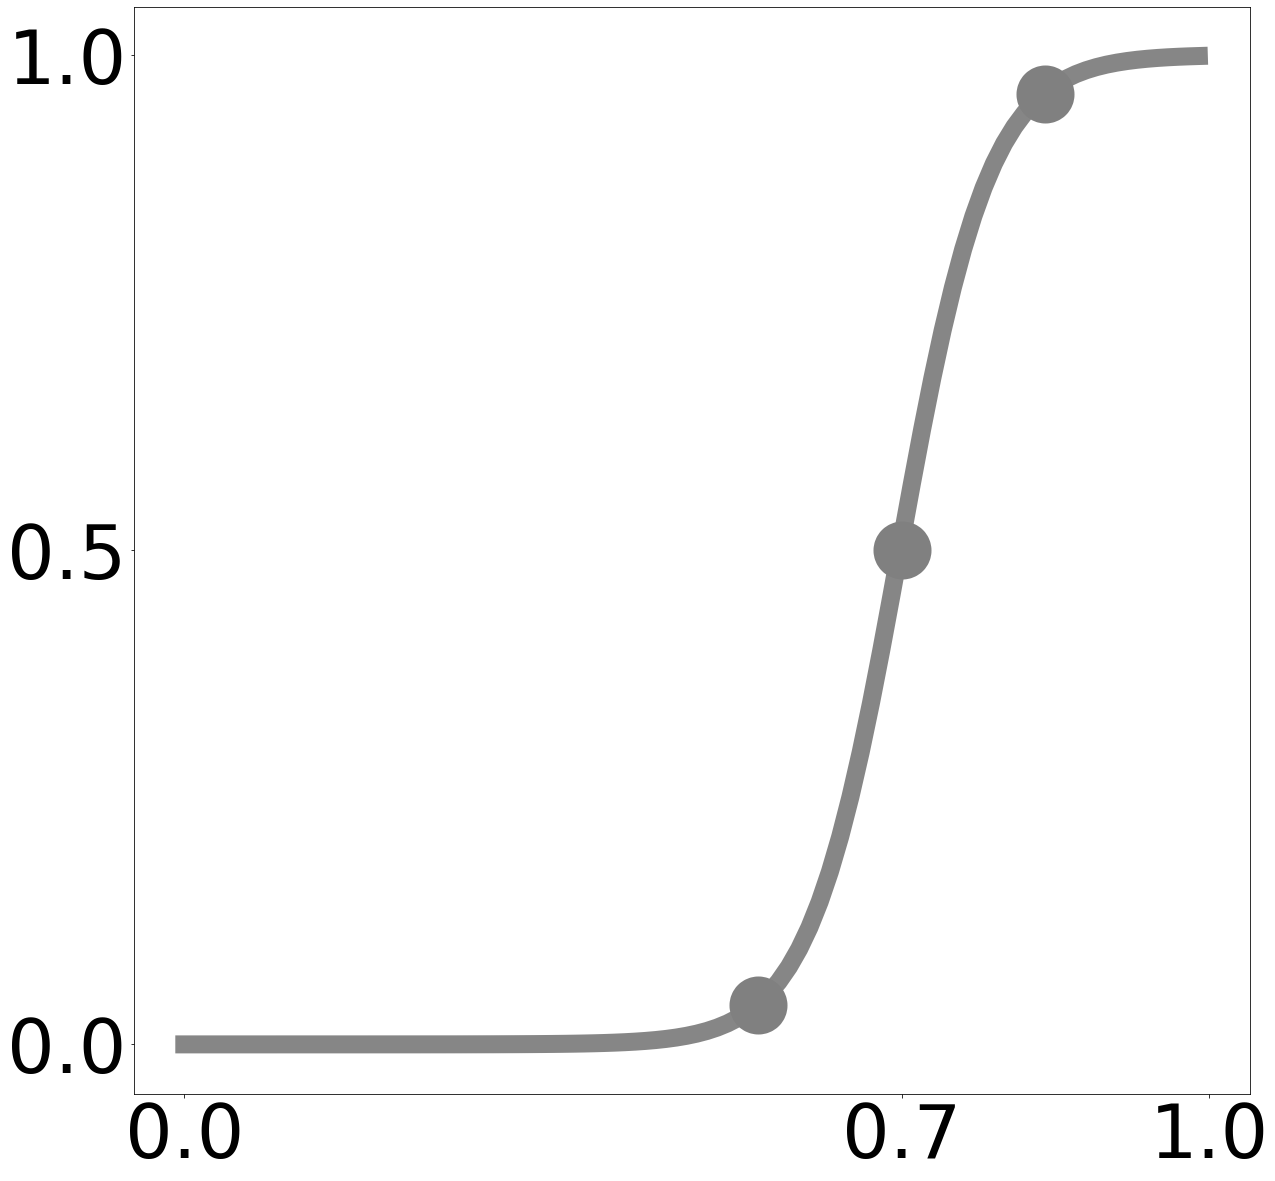

In [30]:
t = np.array([0.635])
x = np.arange(0, 1, 0.01).reshape((1,-1))
y = tf.vectorized_map(fit_sigmoid_heaviside, (x, t))
plt.plot(x[0], y[0], linewidth=LINEWIDTH, alpha=0.95, c="grey")

l=0.14

plt.scatter([0.7-l, 0.7, 0.7+l], [0.04, 0.5, 0.96], facecolors='grey', edgecolors='grey', linewidth=LINEWIDTH, s=POINTSIZE)
#plt.axvline([0.7], color='grey', linestyle='--', linewidth=24)
#plt.axhline(y=0.5, color='grey', linestyle='--', linewidth=24)


plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)
plt.xticks([0, 0.7, 1.0])
plt.yticks([0, 0.5, 1.0])

# #plt.plot(x[0], 1-y[0], linewidth=24, alpha=0.95)
# x2 = np.arange(0, 1, 0.01).reshape((1,-1))
# y2 = tf.vectorized_map(heaviside_approx, (tf.abs(1-x), tf.abs(1-t)))
# plt.plot(x2[0], y2[0], linewidth=24, alpha=0.95)
plt.savefig('plots/heaviside_sigmoid_approx.pdf')
plt.show()

### Heaviside Approximation

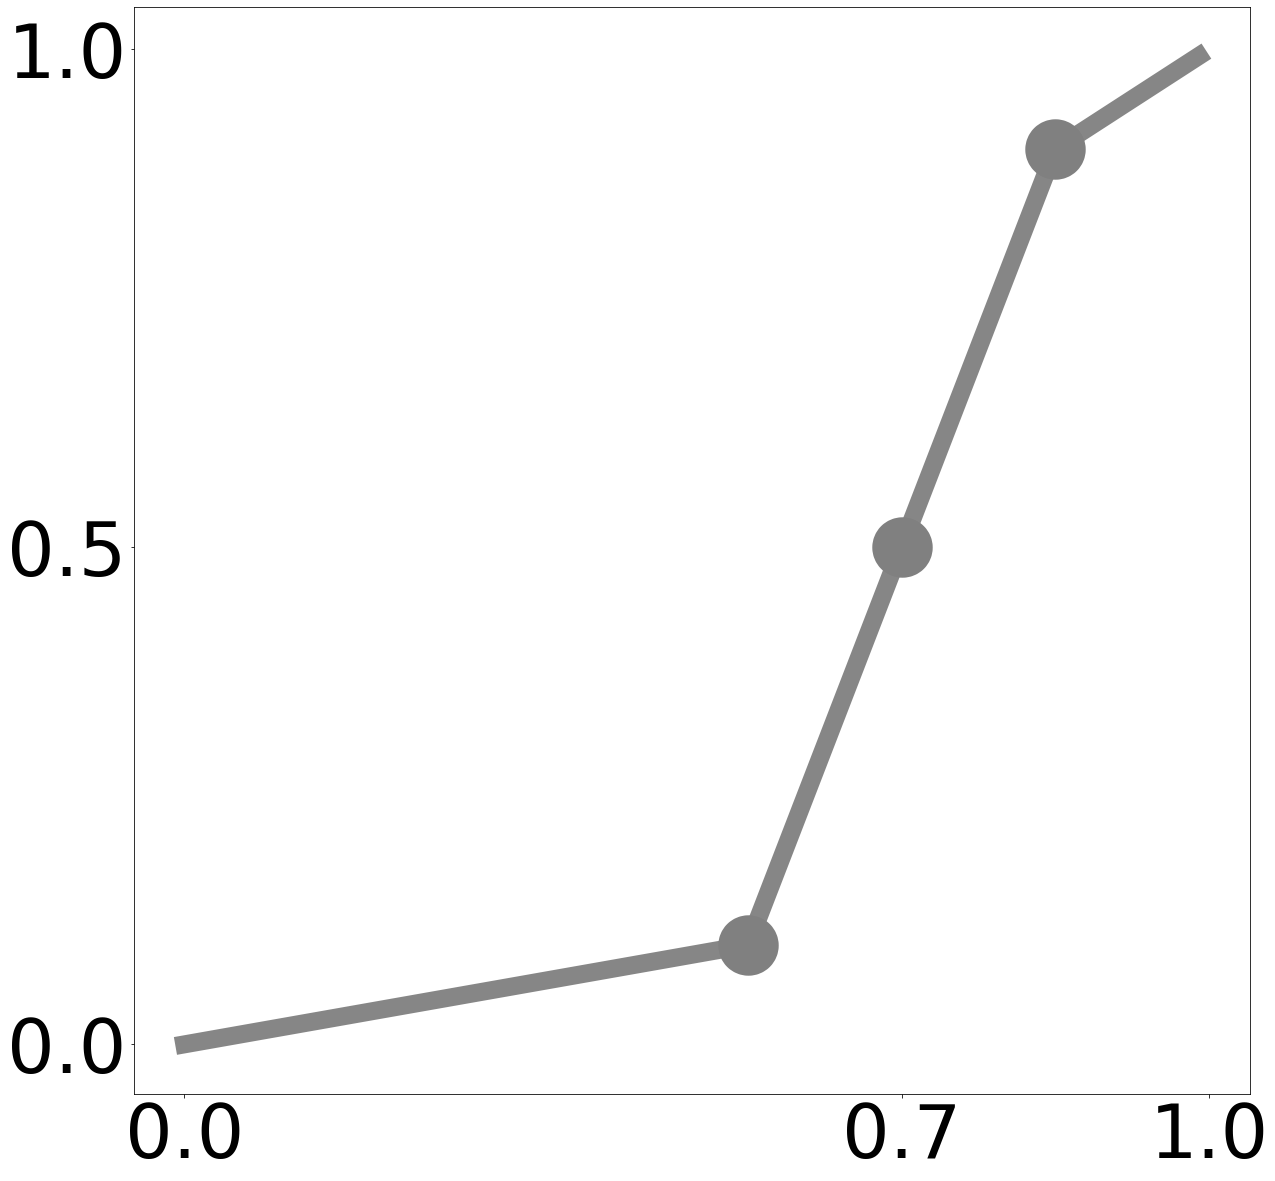

In [31]:
t = np.array([0.7])
x = np.arange(0, 1, 0.01).reshape((1,-1))
y = tf.vectorized_map(heaviside_approx, (x, t))
plt.plot(x[0], y[0], linewidth=LINEWIDTH, alpha=0.95, c="grey")

# #plt.plot(x[0], 1-y[0], linewidth=24, alpha=0.95)
# x2 = np.arange(0, 1, 0.01).reshape((1,-1))
# y2 = tf.vectorized_map(heaviside_approx, (tf.abs(1-x), tf.abs(1-t)))
# plt.plot(x2[0], y2[0], linewidth=24, alpha=0.95)

l=0.15
plt.scatter([0.7-l, 0.7, 0.7+l], [0.1, 0.5, 0.9], facecolors='grey', edgecolors='grey', linewidth=LINEWIDTH, s=1800)
#plt.axvline([0.7], color='grey', linestyle='--', linewidth=24)
#plt.axhline(y=0.5, color='grey', linestyle='--', linewidth=24)
plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)
plt.xticks([0, 0.7, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.savefig('plots/heaviside_linear_approx.pdf')
plt.show()

### Heaviside Approximation Sigmoid

from http://jpeg:9998/notebooks/notebooks/Activation%20Function%20Plots.ipynb#Continuous-Functions

In [32]:
def _wsigma(x, weight, multiplier, thresh):
    multiplier = 10
    s=1/(1+np.exp(-x*weight+weight/2+(multiplier * (0.5-thresh))))
    return s

def _wsigma_dx(x, weight, multiplier, thresh):
    exp = np.exp(multiplier * (0.5 - thresh) - (weight * x) + (weight/2))
    return (weight * exp)/np.power((exp + 1), 2)


def wsigma(x, weight=10, multiplier=10, thresh=0.5):
    '''
    input to wsigma is a probability [0,1]
    invert w/ a negative weight
    parameters:
        x: is the value
        weight: determines the steepness of the slope of the curve
        thresh: determines the threshold for labeling something positive or negative
            at a threshold value of 0.5, inputs > 0.5 output a value closer to 1 and < 0.5, closer to 0
            at a threshold value of 0.9, inputs > 0.9 output a value closer to 1 and < 0.9, closer to 0
    '''
    s = _wsigma(x, weight, multiplier, thresh)
    ds = _wsigma_dx(x, weight, multiplier, thresh)
    return s,ds

#3.14830624 1.57622342
def threshold_input_to_threshold_param(x, w=np.pi, o=np.pi/2):
    return -1 * np.tan((x)*w-o) + 0.5

def lin(x, m, b):
    return m*x+b

def threshold_param_to_weight(x, neg_w_b=[-20.00448894, 23.74890989], pos_w_b=[20.00475821, 3.7403742]):
    ''' There is a linear mapping between these params'''
    return np.where(x < 0.5, lin(x, *neg_w_b), lin(x, *pos_w_b))

def continuous_step_function_sig(x, thresh=np.array([0.5]), inverter=None, sum=True):
    '''
    To invert the output for a given set of samples x, set inverter[i] = -1.
      inverter should have the shape (thresh.shape[0], x.shape[0])
    '''
    # apply the inversion if necessary
    # must be applied to both the threshold and the weight
    if inverter is not None:
        thresh = np.where(inverter == -1, 1 - thresh, thresh)
    else:
        inverter = np.ones_like(x, dtype=np.int32)
    thresh_param = threshold_input_to_threshold_param(thresh)
    wsigmas = []
    for i, t in enumerate(thresh_param):
        weight_param = threshold_param_to_weight(t) * inverter[i]
        ws = wsigma(x, weight_param, thresh=t)
        if sum:
            wsigmas.append([np.sum(ws[0]), np.sum(ws[1])])
        else:
            wsigmas.append(ws)
    # output shape is (thresh.shape[0], x.shape (values), x.shape (derivatives))
    return np.array(wsigmas)

def logistic(x, mu=0.5, s=0.1):
    # exponential term used in the pdf and cdf
    exp = np.exp(-1*(x-mu)/s)
    #cdf
    l = 1/(1+exp)
    #pdf
    ldx = exp/(s*np.power(1+exp, 2))
    return l, ldx

def continuous_step_function_logistic(x, thresh=np.array([0.5]), inverter=None, sigma=0.1, sum=True):
    exps = []
    sigmas = np.fill(inverter.shape, sigma)
    if inverter is not None:
        sigmas = np.where(inverter == -1, sigmas*inverter, sigmas)
    for i, t in enumerate(thresh):
        l, ldx = logistic(x, mu=t, s=sigmas[i])
        if sum:
            exps.append([np.sum(l), np.sum(ldx)])
        else:
            exps.append([l, ldx])
    # output shape is (thresh.shape[0], x.shape (values), x.shape (derivatives))
    return np.array(exps)

continuous_step_function = continuous_step_function_logistic

def c_tp(gt, pt, thresh=np.array([0.5])):
    assert gt.shape == pt.shape
    # output closer to 1 if a true positive, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 1 -> (inverter = 1)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (inverter = 1)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    inverter = np.ones((thresh.shape[0], pt.shape[0]))
    for i, t in enumerate(thresh):
        inverter[i] = np.where((gt == 0) & (pt >= t), -1, 1)
    return continuous_step_function(pt, thresh, inverter)

def c_fn(gt, pt, thresh=np.array([0.5])):
    assert gt.shape == pt.shape
    # output closer to 1 if a false negative, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  fn: (gt == 1 and pt == 0) -> closer to 1 -> (inverter = -1)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    inverter = np.ones((thresh.shape[0], pt.shape[0]))
    for i, t in enumerate(thresh):
        inverter[i] = np.where((gt == 0) & (pt < t), 1, -1)
    return continuous_step_function(pt, thresh, inverter)

def c_fp(gt, pt, thresh=np.array([0.5])):
    assert gt.shape == pt.shape
    # output closer to 1 if a false positive, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (inverter = 1)
    #  fp: (gt == 0 and pt == 1) -> closer to 1 -> (inverter = 1)
    #  tn: (gt == 0 and pt == 0) -> closer to 0 -> (inverter = 1)
    inverter = np.ones((thresh.shape[0], pt.shape[0]))
    for i, t in enumerate(thresh):
        inverter[i] = np.where((gt == 1) & (pt >= t), -1, 1)
    return continuous_step_function(pt, thresh, inverter)

def c_tn(gt, pt, thresh=np.array([0.5])):
    assert gt.shape == pt.shape
    # output closer to 1 if a true negative, else closer to 0
    #  tp: (gt == 1 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  fn: (gt == 1 and pt == 0) -> closer to 0 -> (inverter = 1)
    #  fp: (gt == 0 and pt == 1) -> closer to 0 -> (inverter = -1)
    #  tn: (gt == 0 and pt == 0) -> closer to 1 -> (inverter = -1)
    inverter = np.ones((thresh.shape[0], pt.shape[0]))
    for i, t in enumerate(thresh):
        inverter[i] = np.where((gt == 1) & (pt < t), 1, -1)
    return continuous_step_function(pt, thresh, inverter)

def c_precision(gt, pt, thresh=0.5):
    ''' precision at a given threshold '''
    _c_tp = c_tp(gt, pt, thresh)
    #print("tp:", _c_tp)
    _c_fp = c_fp(gt, pt, thresh)
    #print("fp:", _c_fp)
    return _c_tp/(_c_tp + _c_fp)

def c_recall(gt, pt, thresh=0.5):
    ''' recall at a given threshold '''
    _c_tp = c_tp(gt, pt, thresh)
    _c_fn = c_fn(gt, pt, thresh)
    return _c_tp/(_c_tp + _c_fn)

def c_pr(gt, pt, thresholds):
    return (c_precision(gt, pt, thresholds)[:,0], c_recall(gt, pt, thresholds)[:,0])


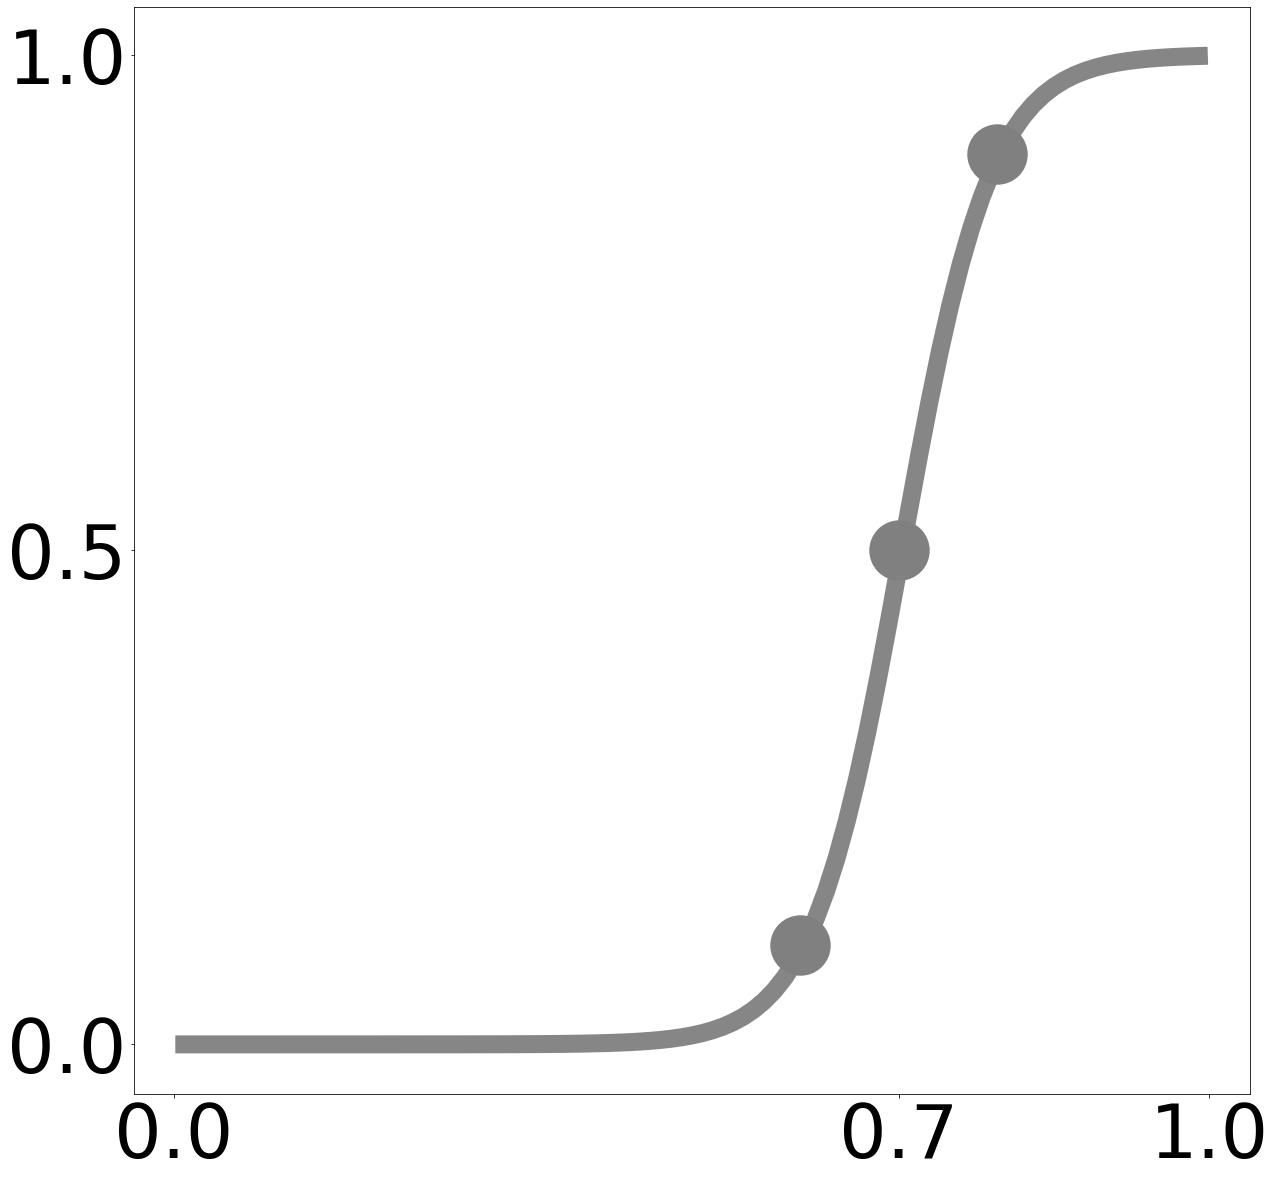

In [33]:
t = threshold_input_to_threshold_param(0.64)
w = threshold_param_to_weight(t)
x = np.arange(0.01,1,0.01)

plt.plot(x, _wsigma(x, w, 10, t), linewidth=LINEWIDTH, alpha=0.95, c="grey")

l=0.095
plt.scatter([0.7-l, 0.7, 0.7+l], [0.1, 0.5, 0.9], facecolors='grey', edgecolors='grey', linewidth=LINEWIDTH, s=1800)
#plt.axvline([0.7], color='grey', linestyle='--', linewidth=24)
#plt.axhline(y=0.5, color='grey', linestyle='--', linewidth=24)
plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)
plt.xticks([0, 0.7, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.savefig('plots/heaviside_sigmoid_fit_approx.pdf')
plt.show()

## Hill approximation

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


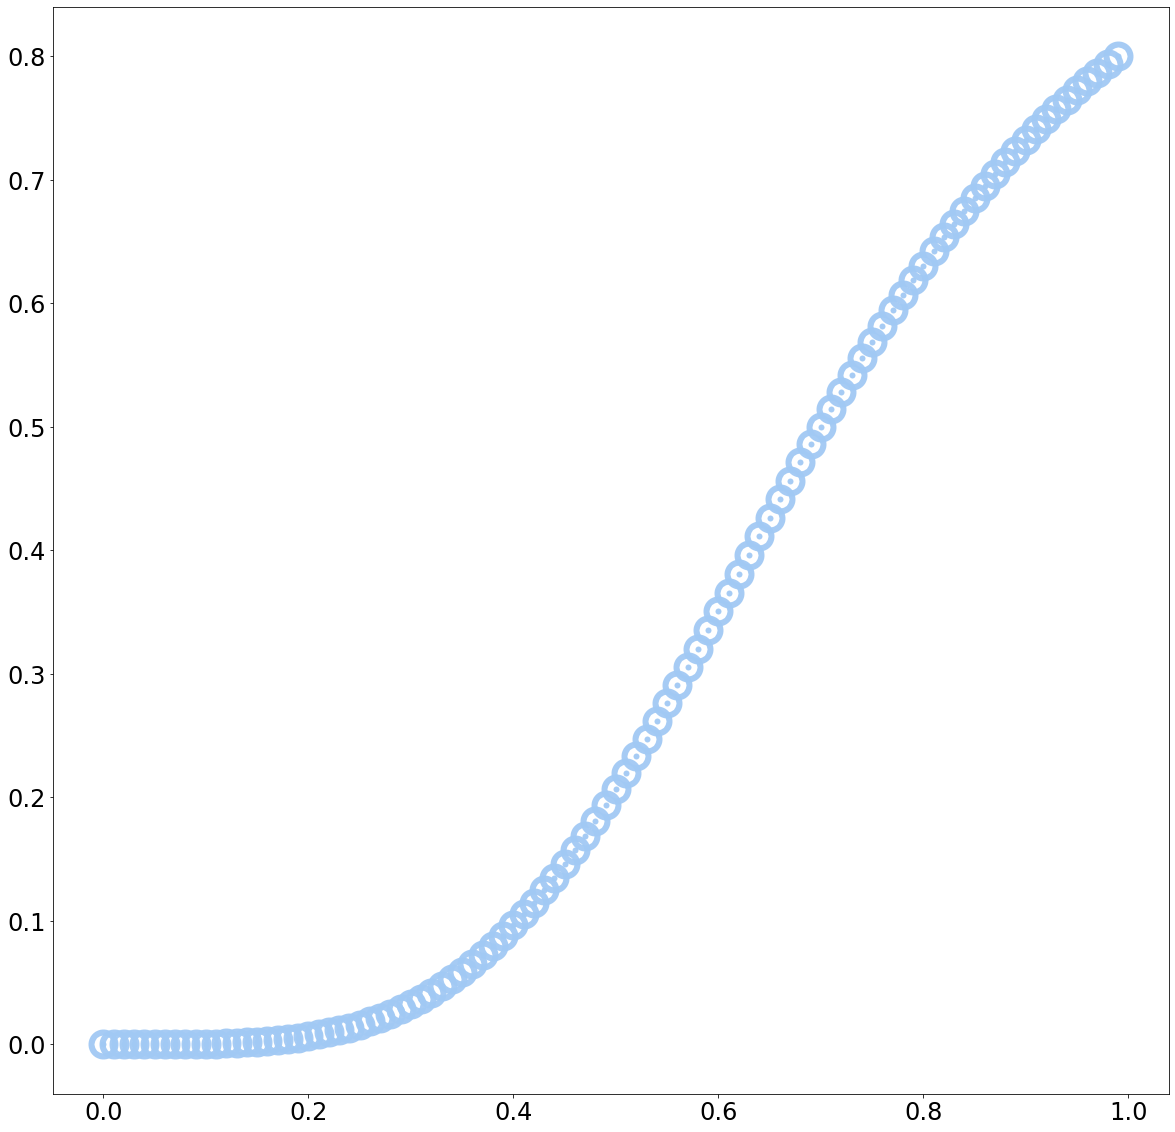

In [34]:
def hill(x, t=0.5, n=4):
    return np.power(x, n) / (np.power(t, n) + np.power(x, n))
t = 0.7
x = np.arange(0, 1, 0.01)
plt.scatter(x, hill(x, t), linewidth=24, alpha=0.95)
#plt.scatter(x, hill(1-x, 1-t), linewidth=24, linestyle="--", alpha=0.95)
plt.show()

# Experiment 1

Sigmoid vs Linear Heaviside Approximation

In [35]:
EXP1 = 't52'
df1 = load_final(EXP1)

looking for ../experiments/*/t52/*/*_test_final.pkl
loading 390 pkls


In [36]:
df1

,dataset,loss,threshold,f1,accuracy,precision,recall,ap,pr_auc,roc_auc,tpr,fpr,tn,fp,fn,tp,experiment_id
1,synthetic,f1_mean_sig_fit,0.001,0.834480,0.819500,0.771841,0.908184,0.746973,0.757237,0.819322,0.771841,0.555217,729,269,92,910,1
2,synthetic,f1_mean_sig_fit,0.002,0.834943,0.820500,0.774084,0.906188,0.748465,0.759017,0.820328,0.774084,0.553321,733,265,94,908,1
3,synthetic,f1_mean_sig_fit,0.003,0.835711,0.821500,0.775406,0.906188,0.749663,0.760259,0.821330,0.775406,0.552648,735,263,94,908,1
4,synthetic,f1_mean_sig_fit,0.004,0.835560,0.821500,0.775877,0.905190,0.749816,0.760536,0.821332,0.775877,0.552039,736,262,95,907,1
5,synthetic,f1_mean_sig_fit,0.005,0.835945,0.822000,0.776541,0.905190,0.750417,0.761160,0.821833,0.776541,0.551703,737,261,95,907,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389995,synthetic_05,f1_mean_sig_k10,0.995,0.511628,0.960000,0.733333,0.392857,0.320476,0.352775,0.692404,0.733333,0.021825,986,8,34,22,7
389996,synthetic_05,f1_mean_sig_k10,0.996,0.494118,0.959048,0.724138,0.375000,0.304885,0.336933,0.683476,0.724138,0.020854,986,8,35,21,7
389997,synthetic_05,f1_mean_sig_k10,0.997,0.481928,0.959048,0.740741,0.357143,0.298836,0.330995,0.675050,0.740741,0.019861,987,7,36,20,7
389998,synthetic_05,f1_mean_sig_k10,0.998,0.450000,0.958095,0.750000,0.321429,0.277262,0.308964,0.657696,0.750000,0.017893,988,6,38,18,7


In [37]:
df1.loss.unique()

array(['f1_mean_sig_fit', 'f1_05_sig_k20', 'f1_mean_sig_k10', 'f1_05',
       'f1_05_sig_fit', 'f1_05_sig_k10', 'f1_mean_sig_k20', 'roc',
       'accuracy_05', 'f3_05', 'bce', 'f2_05', 'f1_mean'], dtype=object)

In [38]:
df1.dataset.unique()

array(['synthetic', 'synthetic_05', 'synthetic_33'], dtype=object)

In [39]:
DATASETS = df1.dataset.unique()
METRICS = ['accuracy', 'f1', 'precision', 'recall']
LOSSES = df1.loss.unique()
cols = ['dataset', 'loss', 'metric', 'value', 'threshold']
THRESHOLDS = [0.5]
df_dict = {}
for col in cols:
    df_dict[col] = []
for ds in DATASETS:
    for loss in LOSSES:
        # array of metric values across trials
        for metric in METRICS:
            for i, row in df1[(df1['dataset']==ds)&(df1['loss']==loss)].iterrows():
                df_dict['loss'].append(loss)
                df_dict['dataset'].append(ds)
                df_dict['metric'].append(metric)
                df_dict['threshold'].append(row.threshold)
                df_dict['value'].append(row[metric])
df1p = pd.DataFrame.from_dict(df_dict)


In [40]:
df1p

,dataset,loss,metric,value,threshold
0,synthetic,f1_mean_sig_fit,accuracy,0.819500,0.001
1,synthetic,f1_mean_sig_fit,accuracy,0.820500,0.002
2,synthetic,f1_mean_sig_fit,accuracy,0.821500,0.003
3,synthetic,f1_mean_sig_fit,accuracy,0.821500,0.004
4,synthetic,f1_mean_sig_fit,accuracy,0.822000,0.005
...,...,...,...,...,...
1558435,synthetic_33,f1_mean,recall,0.803883,0.995
1558436,synthetic_33,f1_mean,recall,0.800000,0.996
1558437,synthetic_33,f1_mean,recall,0.798058,0.997
1558438,synthetic_33,f1_mean,recall,0.796117,0.998


In [41]:
df1p.metric.unique()

array(['accuracy', 'f1', 'precision', 'recall'], dtype=object)

In [42]:
df1p.threshold.unique()

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
       0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
       0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
       0.127, 0.128,

### Experiment 1 Tabular results

In [43]:
_df = df1p
# one table per dataset
for ds in DATASETS:
    print(ds)
    rows = [','.join(METRICS)]
    for loss in LOSSES:
        print("LOSS:", loss)
        row = [loss]
        for metric in METRICS:
            v = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)].value
            print("METRIC ({}): {:.03f}".format(metric, v.mean()))
            row.append("${:.03f} \pm {:.03f}$".format(v.mean(), v.std()))
        rows.append(','.join(row))
    print("--- copy {} ---".format(ds))
    print("\n".join(rows))

synthetic
LOSS: f1_mean_sig_fit
METRIC (accuracy): 0.837
METRIC (f1): 0.845
METRIC (precision): 0.810
METRIC (recall): 0.883
LOSS: f1_05_sig_k20
METRIC (accuracy): 0.838
METRIC (f1): 0.844
METRIC (precision): 0.812
METRIC (recall): 0.881
LOSS: f1_mean_sig_k10
METRIC (accuracy): 0.838
METRIC (f1): 0.846
METRIC (precision): 0.802
METRIC (recall): 0.895
LOSS: f1_05
METRIC (accuracy): 0.838
METRIC (f1): 0.846
METRIC (precision): 0.812
METRIC (recall): 0.882
LOSS: f1_05_sig_fit
METRIC (accuracy): 0.839
METRIC (f1): 0.845
METRIC (precision): 0.811
METRIC (recall): 0.883
LOSS: f1_05_sig_k10
METRIC (accuracy): 0.838
METRIC (f1): 0.845
METRIC (precision): 0.806
METRIC (recall): 0.888
LOSS: f1_mean_sig_k20
METRIC (accuracy): 0.839
METRIC (f1): 0.846
METRIC (precision): 0.810
METRIC (recall): 0.885
LOSS: roc
METRIC (accuracy): 0.573
METRIC (f1): 0.532
METRIC (precision): 0.561
METRIC (recall): 0.694
LOSS: accuracy_05
METRIC (accuracy): 0.845
METRIC (f1): 0.845
METRIC (precision): 0.846
METRIC (re

### Experiment 1 plots

[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]


findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


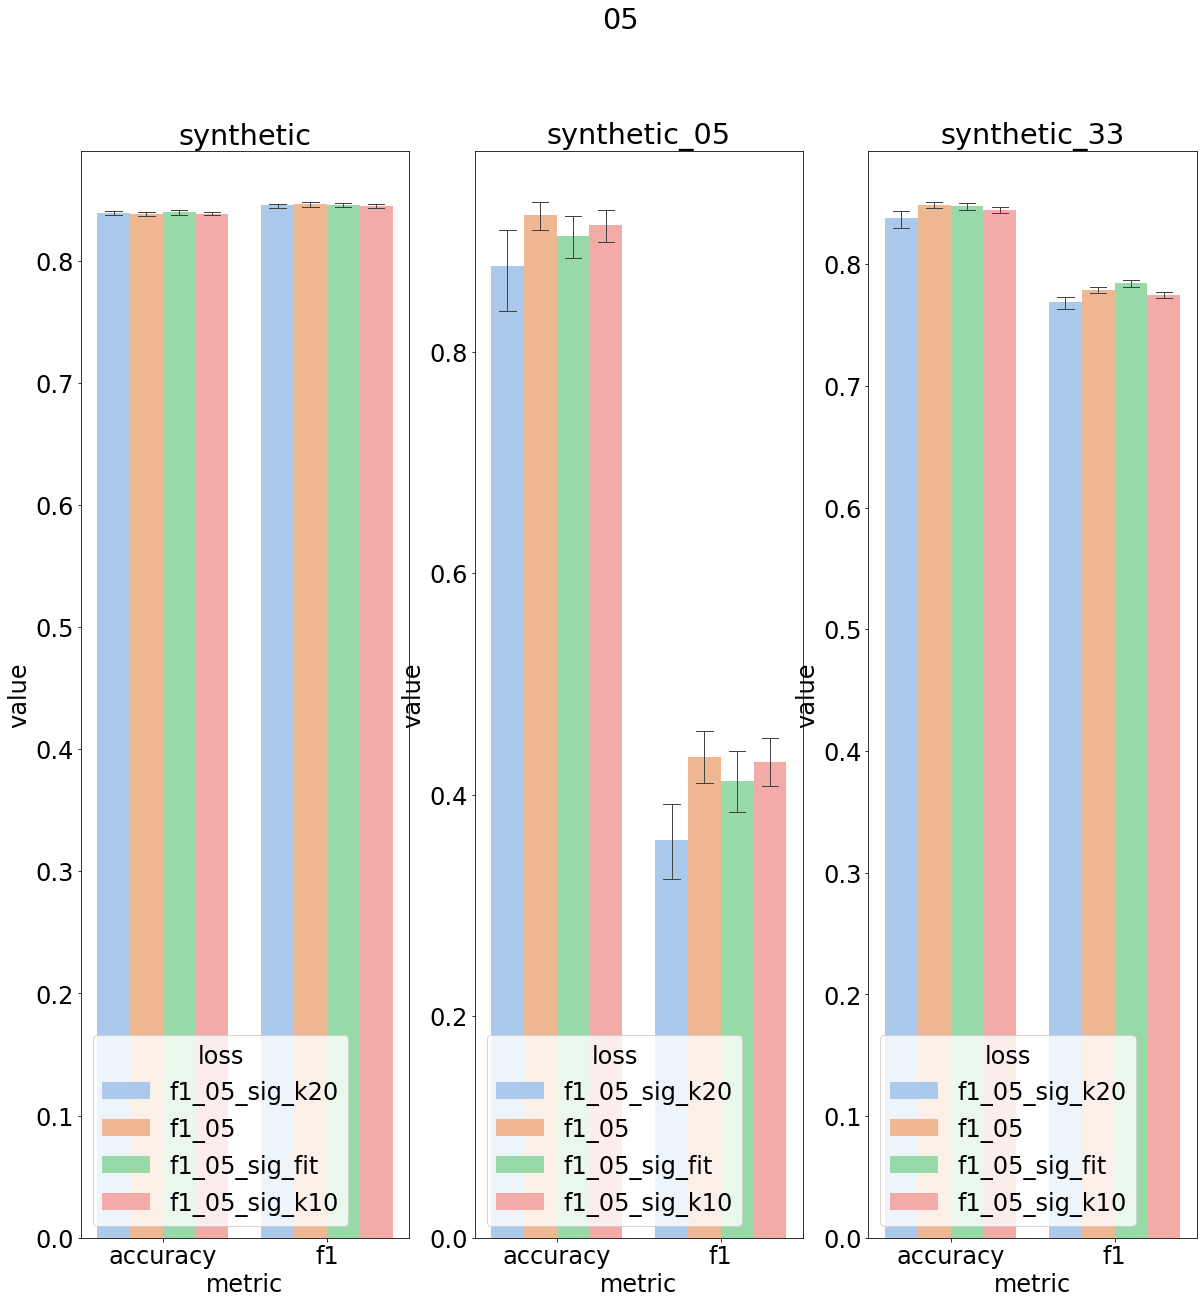

[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.4 0.5 0.6 0.7 0.8 0.9]


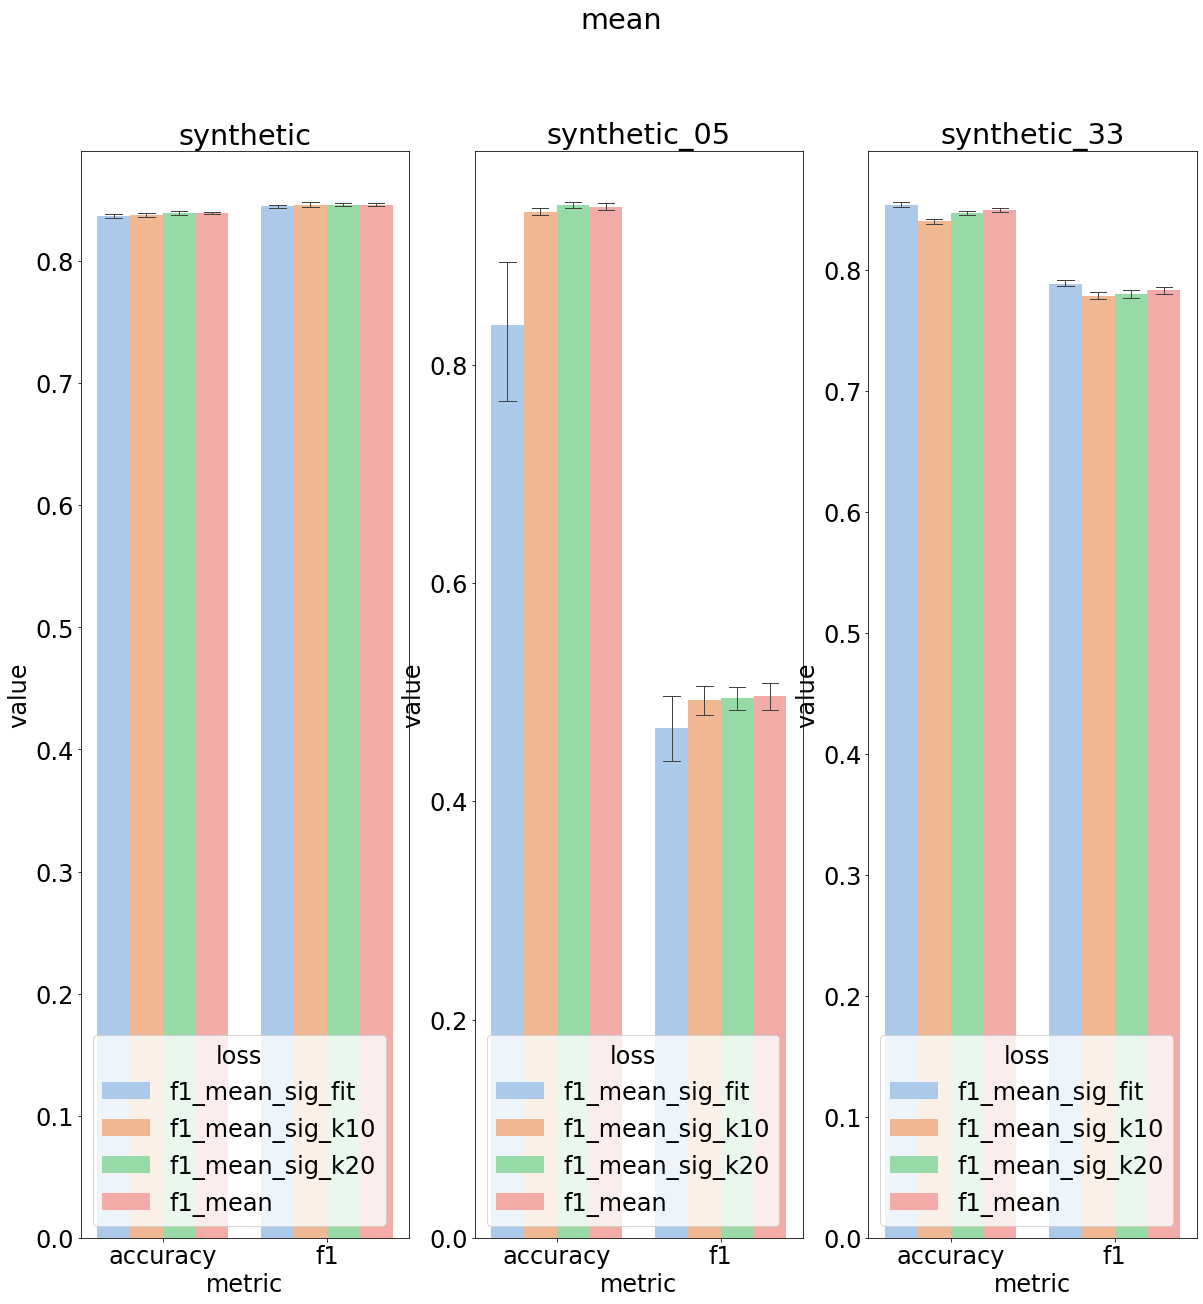

In [44]:
METRICS = ['accuracy', 'f1']
LOSSES = {
    '05': ['f1_05', 'f1_05_sig_k10', 'f1_05_sig_k20', 'f1_05_sig_fit'],
    'mean': ['f1_mean', 'f1_mean_sig_k10', 'f1_mean_sig_k20', 'f1_mean_sig_fit']
}
THRESHOLDS=np.arange(0.1,1,0.1)
_df = df1p
for name, losses in LOSSES.items():
    fig, axs = plt.subplots(1, len(_df.dataset.unique()))
    fig.suptitle(name)
    for i, ds in enumerate(_df.dataset.unique()):
        _adf = _df[(_df["dataset"]==ds)&(_df['metric'].isin(METRICS))&(_df['loss'].isin(losses))&(_df['threshold'].isin(THRESHOLDS))]
        print(_adf.threshold.unique())
        axs[i].set_title(ds)
        sns.barplot(x="metric", y="value", data=_adf, hue="loss", capsize=.1, errwidth=1.0, ax=axs[i])
    plt.show()

In [45]:
def find_neighbours(df, value):
    exactmatch=df[df.threshold==value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df.threshold<value].threshold.idxmax()
        upperneighbour_ind = df[df.threshold>value].threshold.idxmin()
        return [lowerneighbour_ind, upperneighbour_ind]

0.1
99
0.2
199
0.3
299
0.4
399
0.5
499
0.6
599
0.7
698
0.8
799
0.9
899
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6990000000000001, 0.8, 0.9]


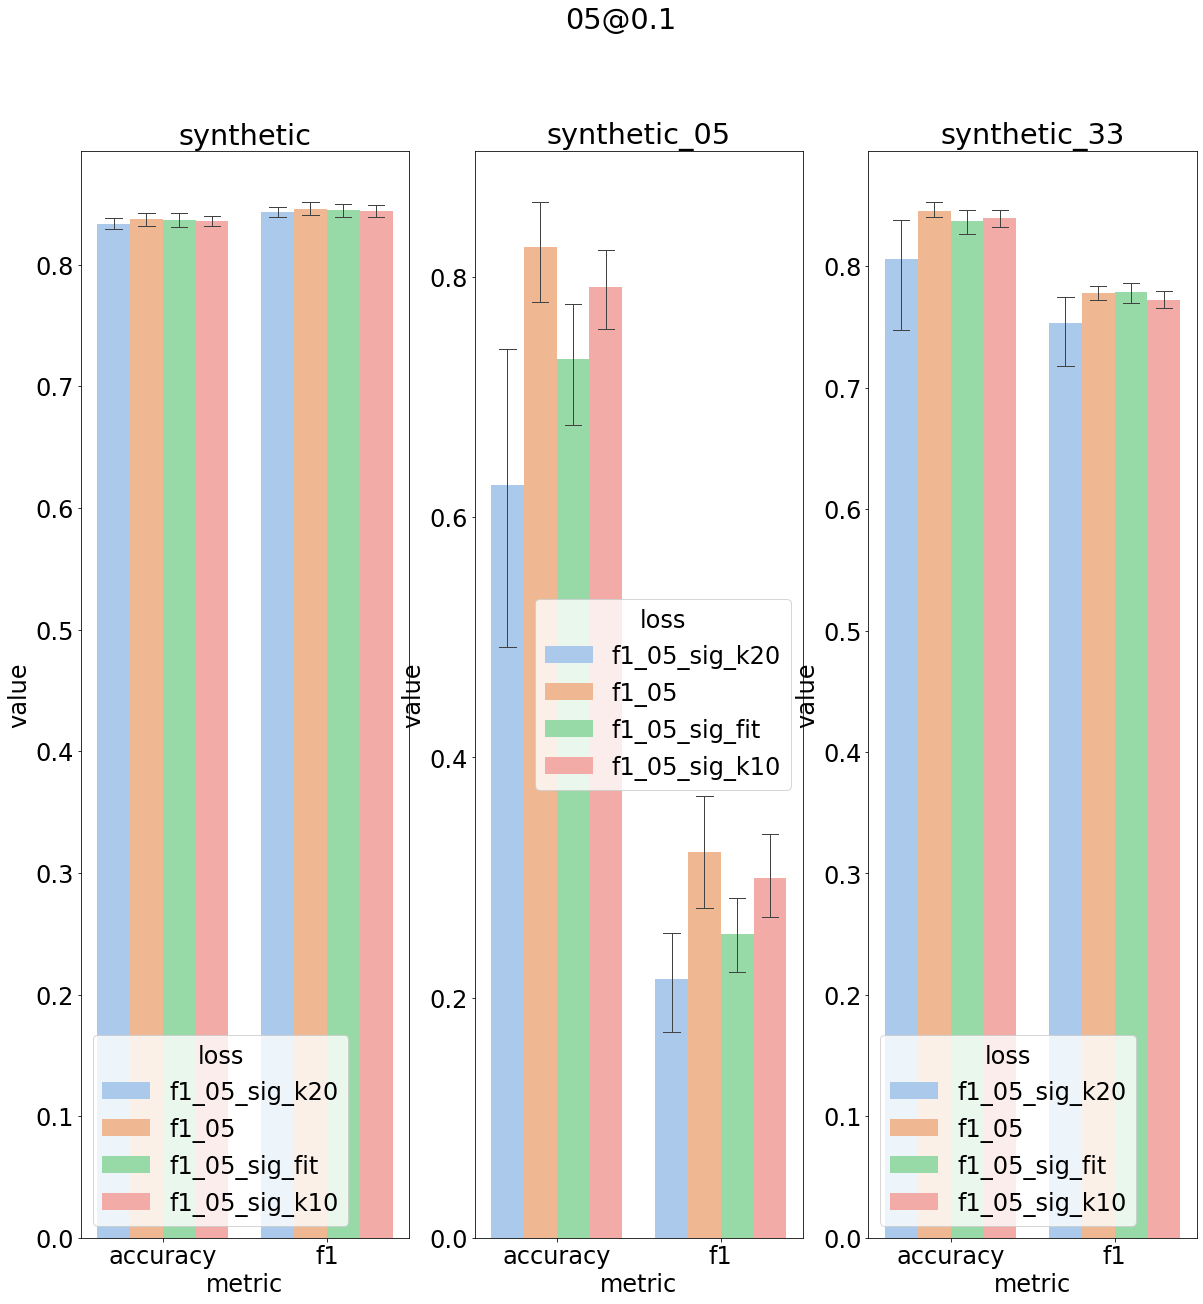

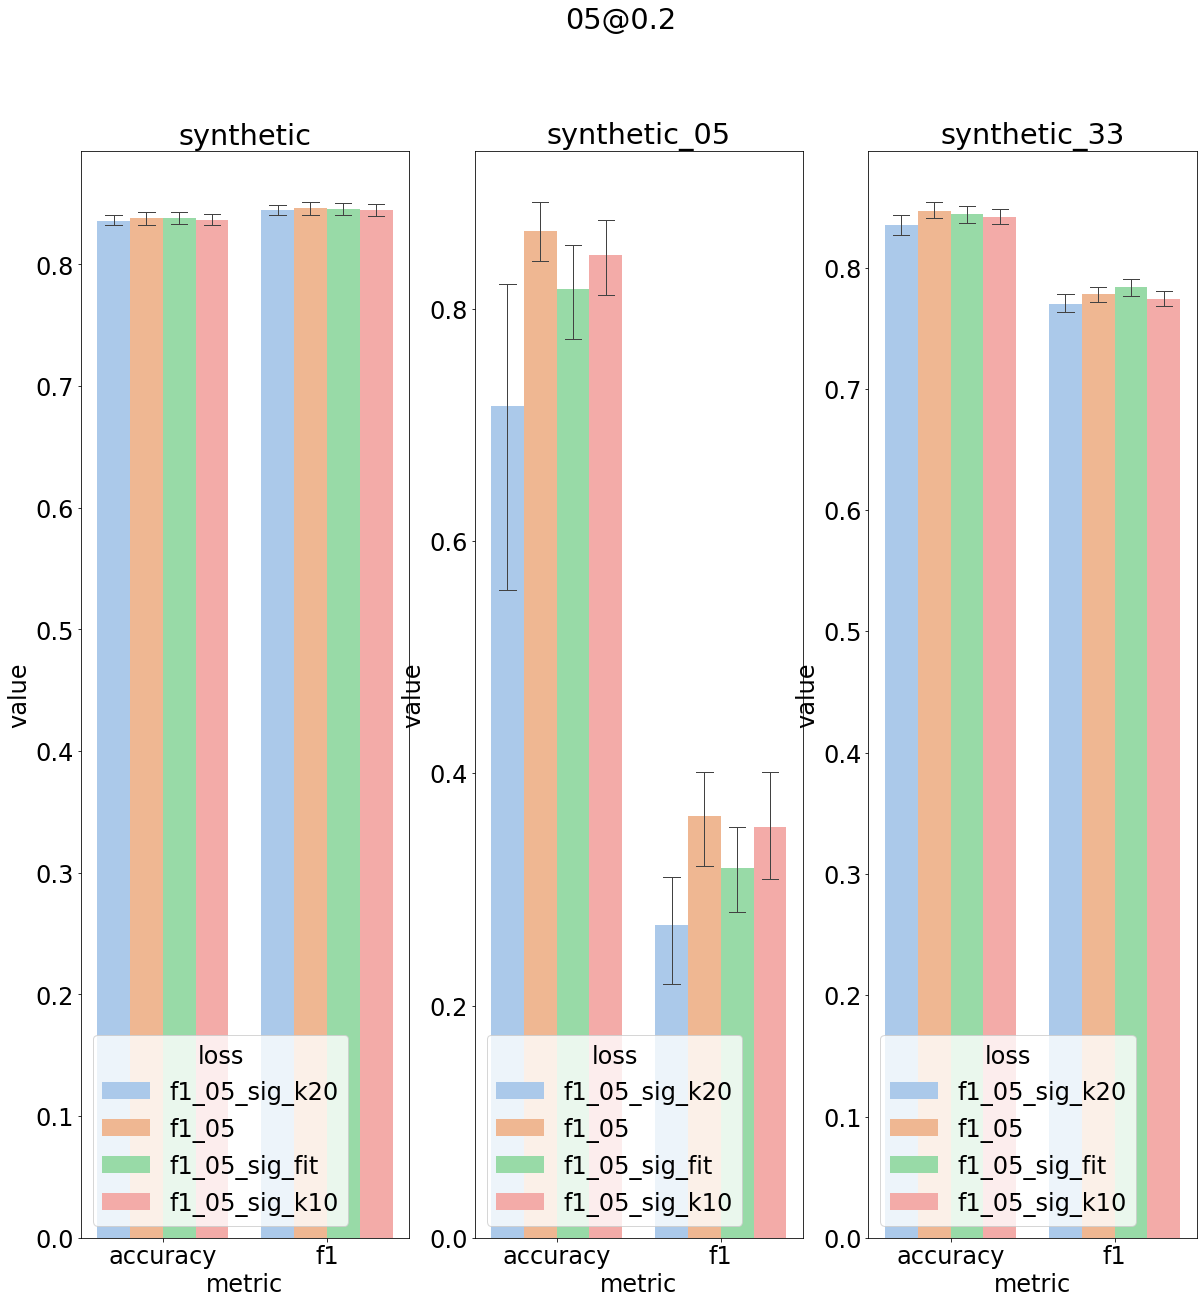

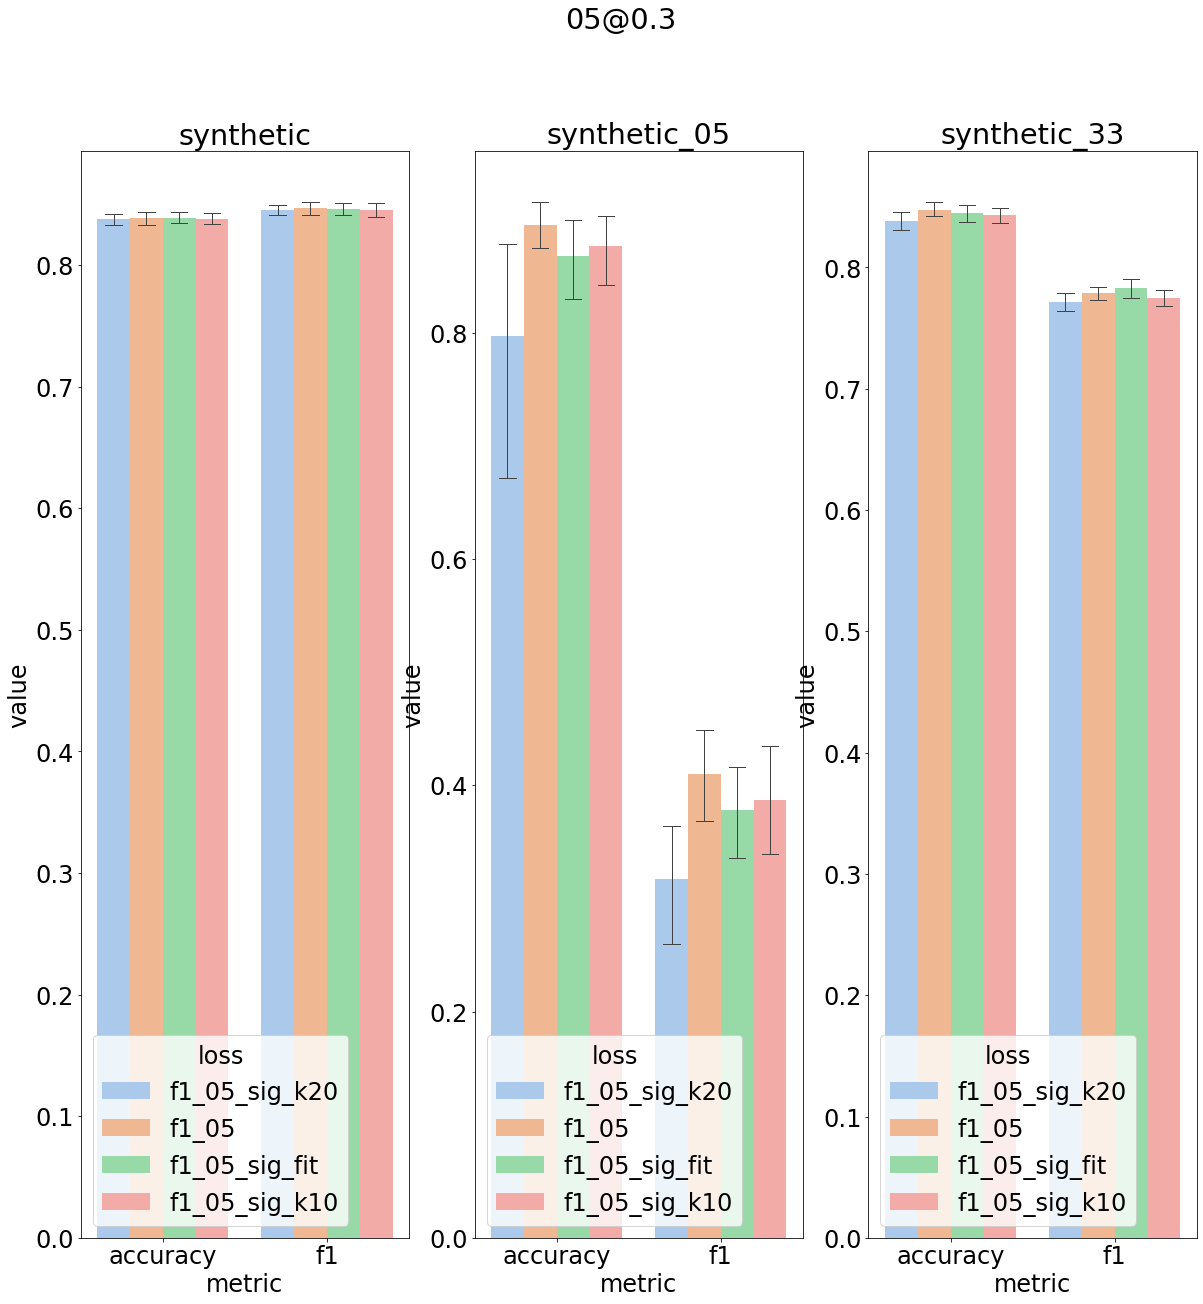

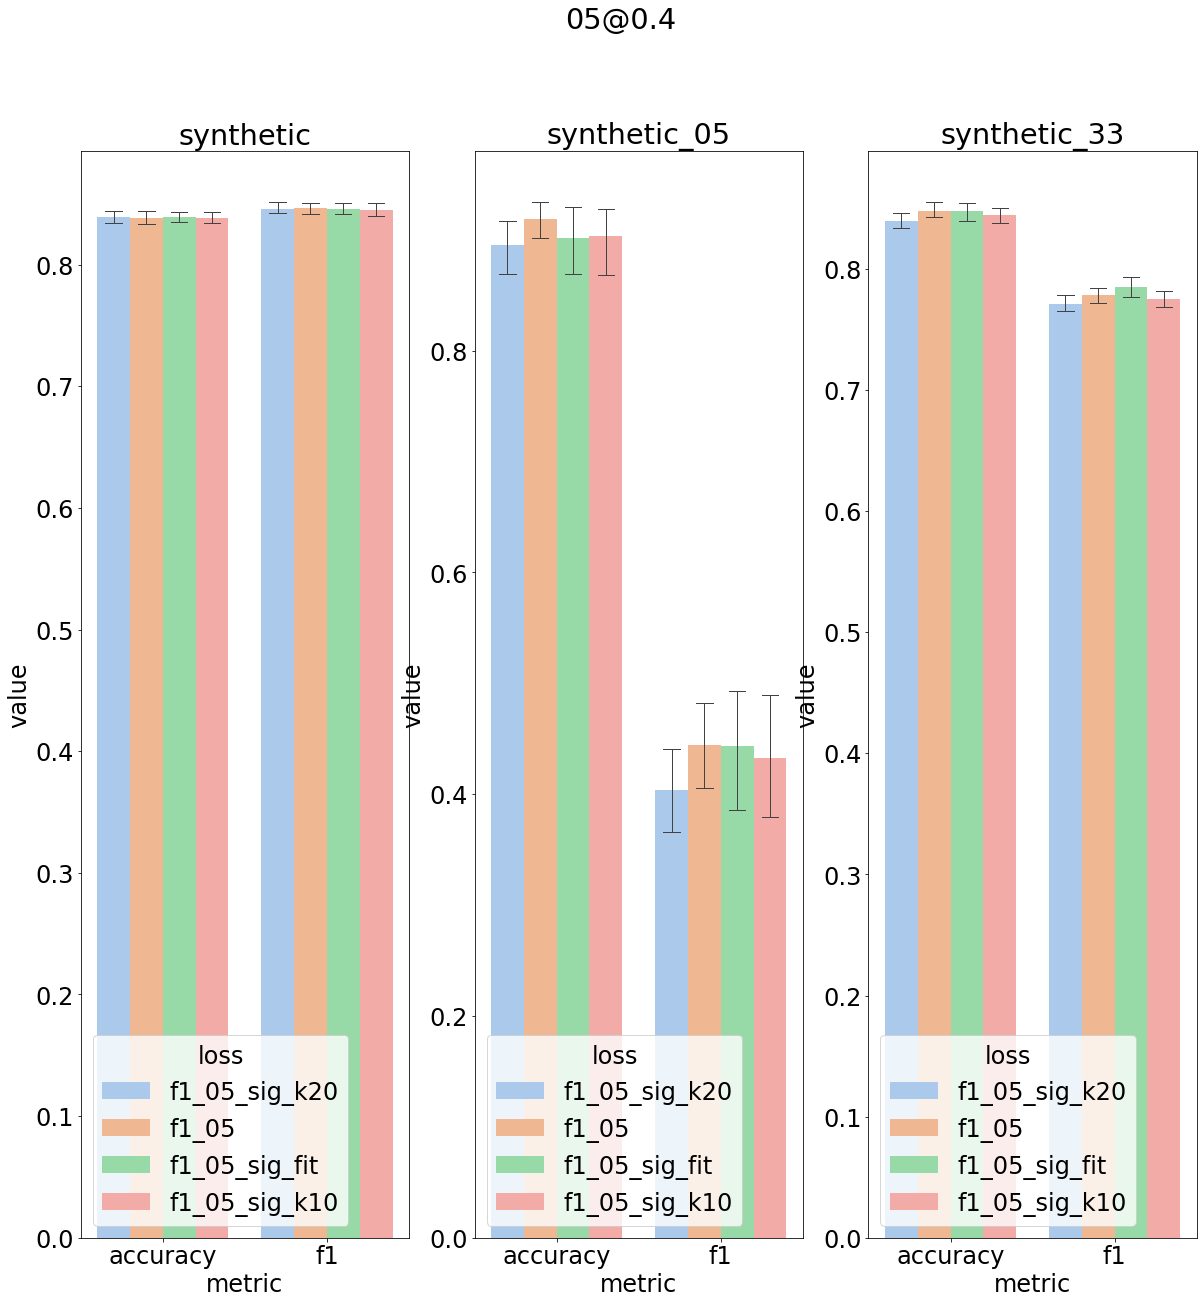

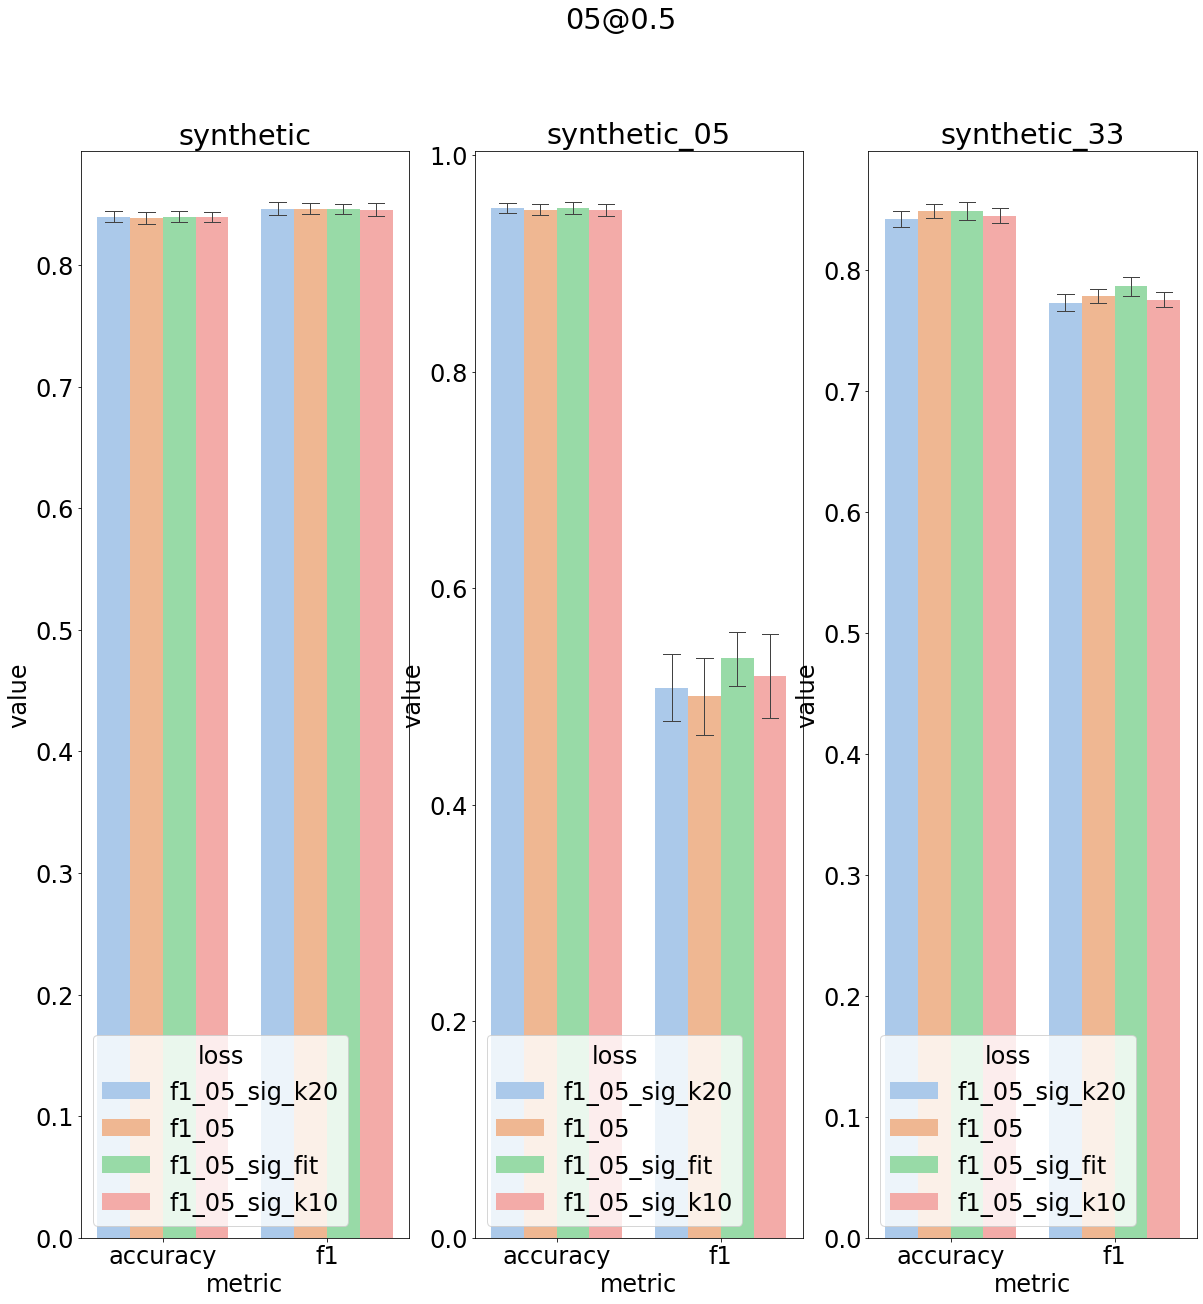

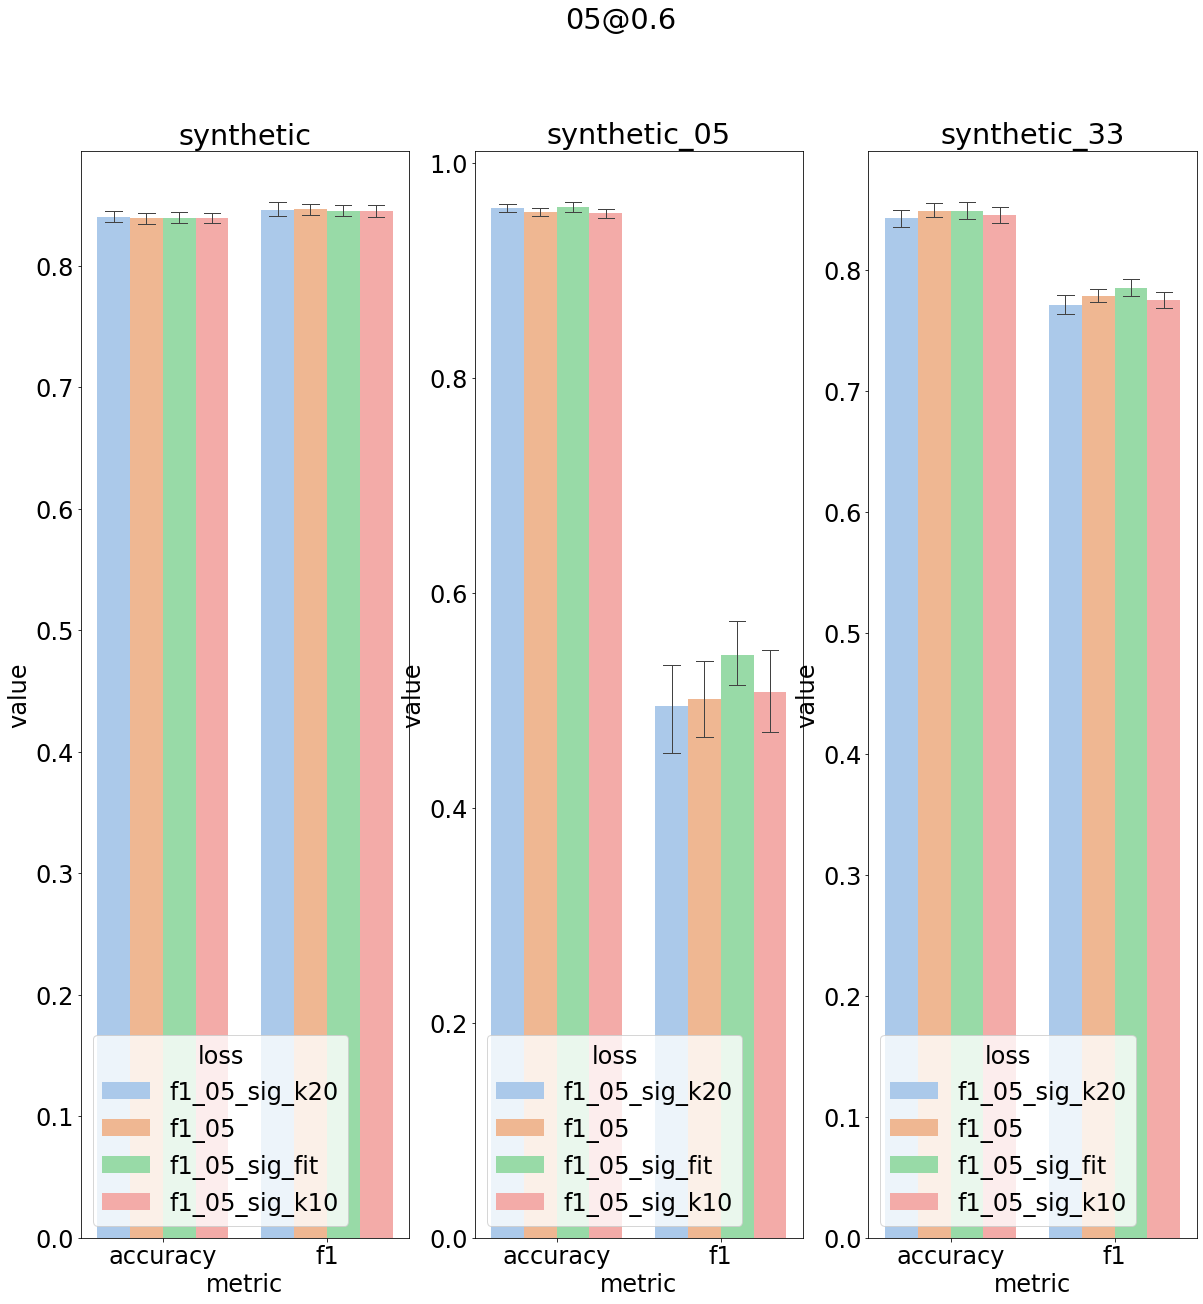

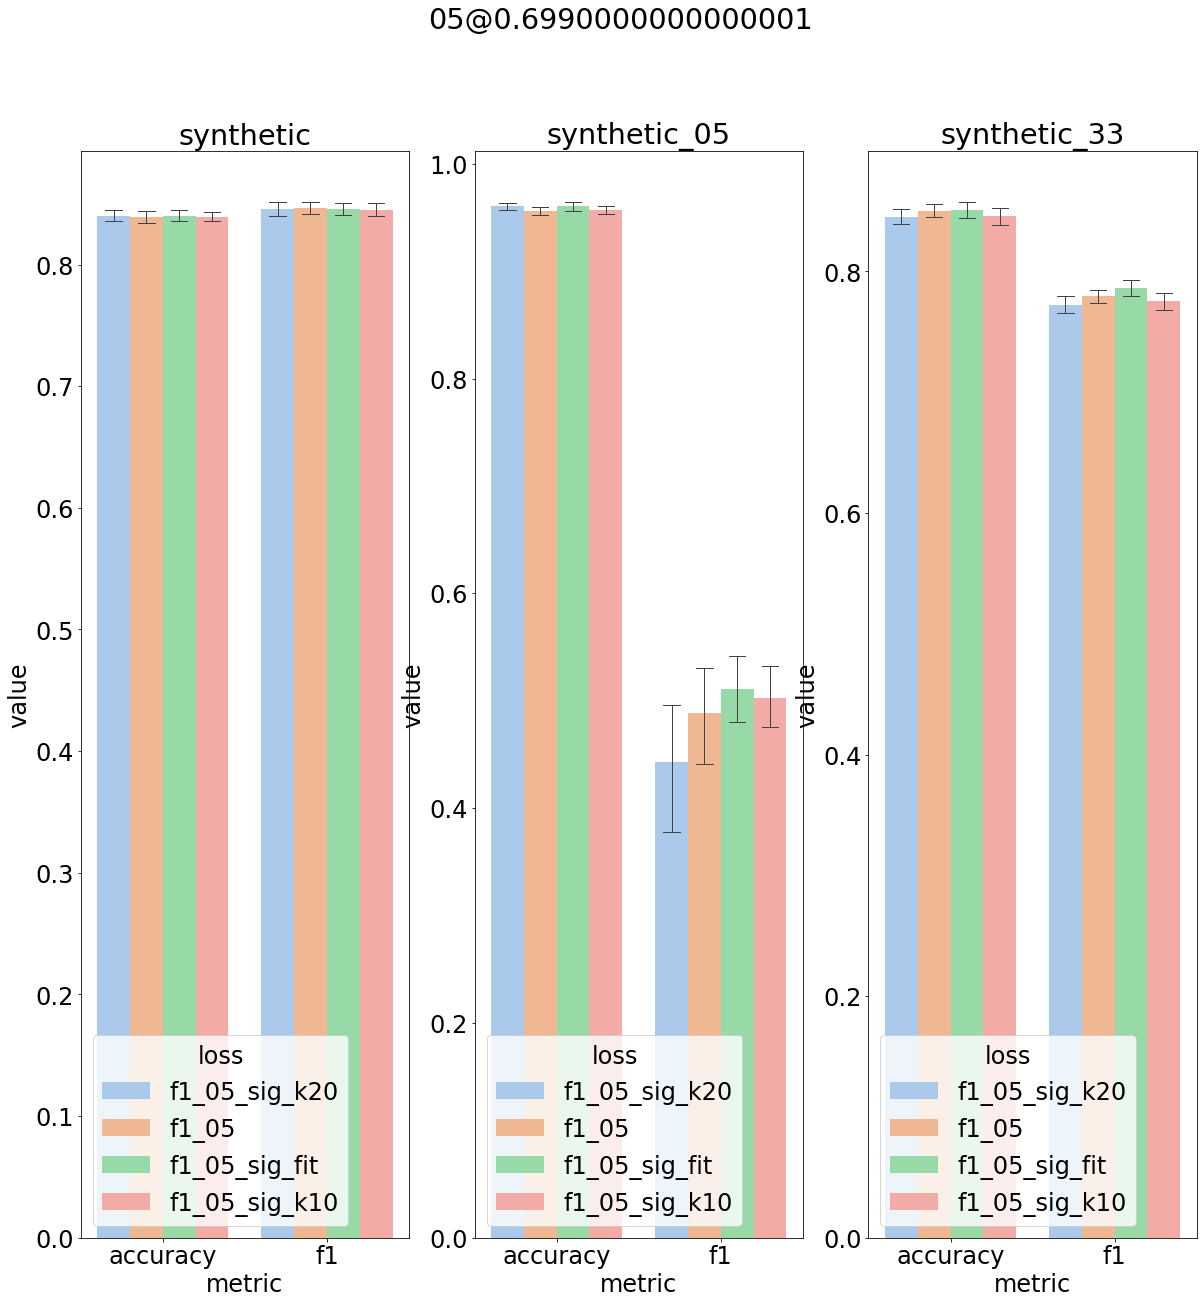

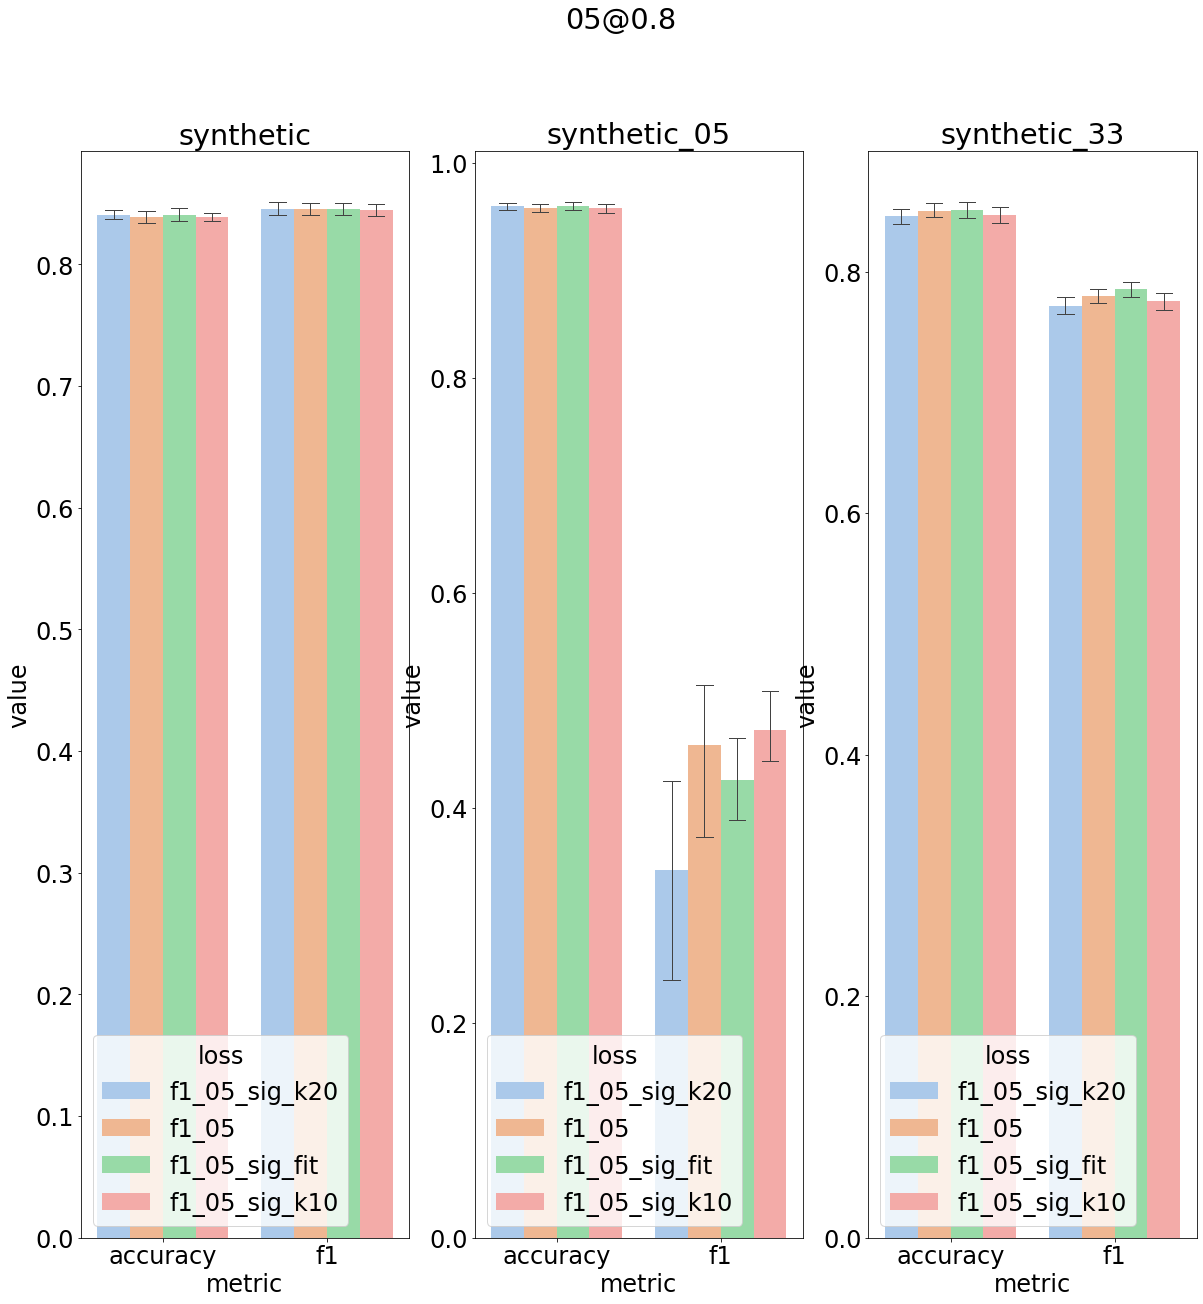

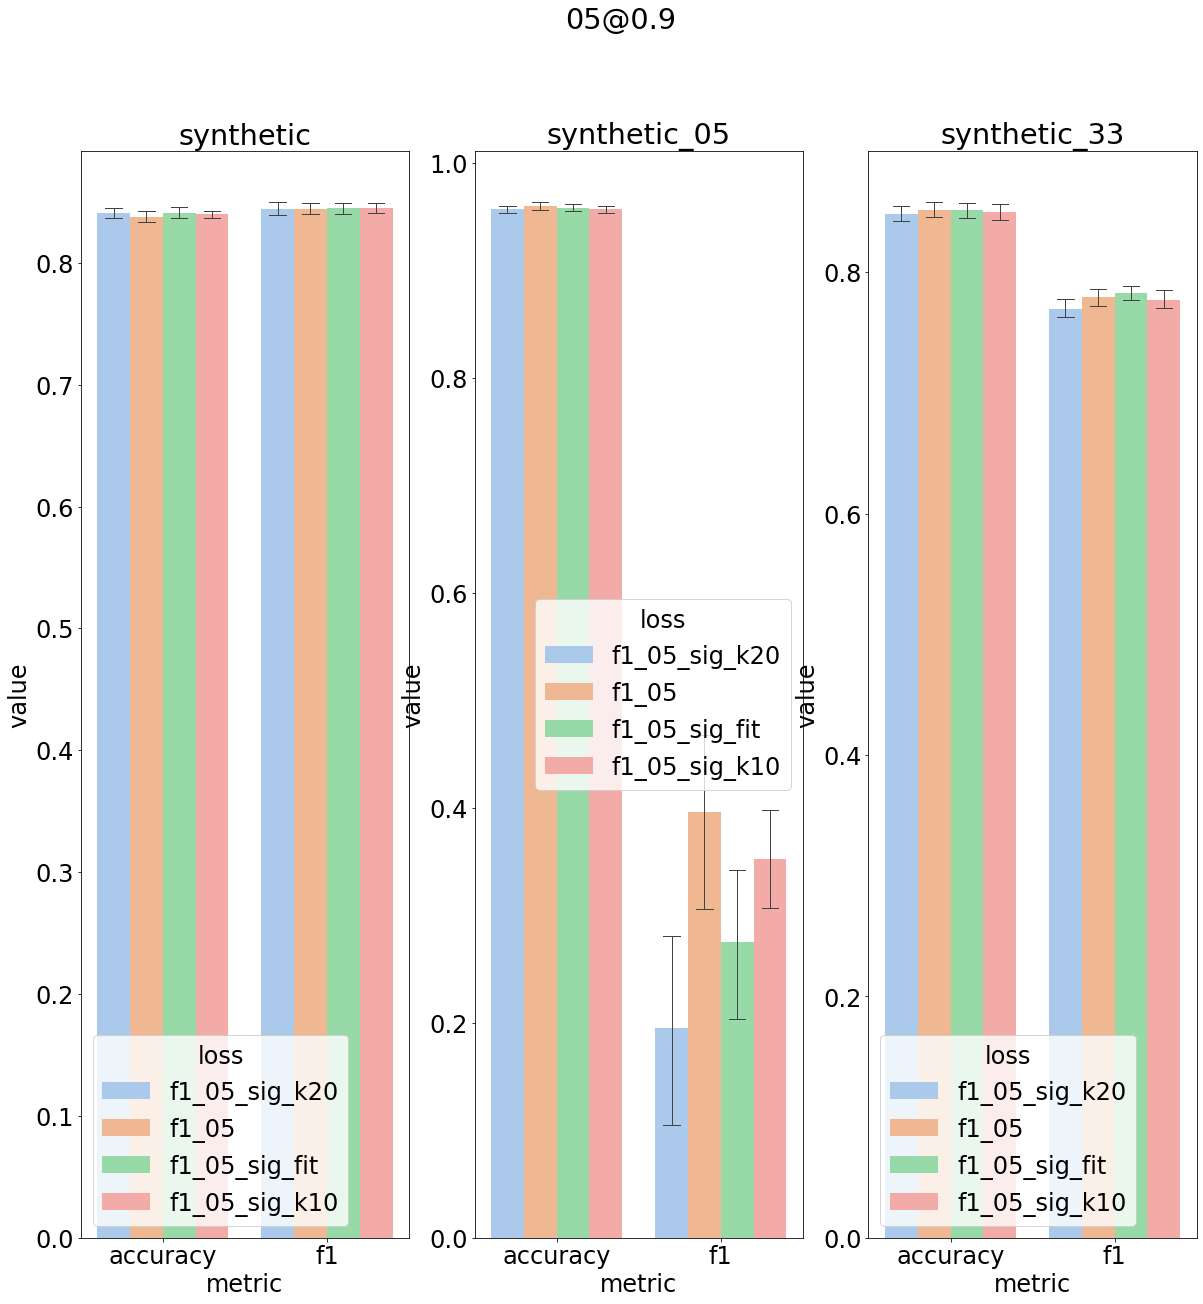

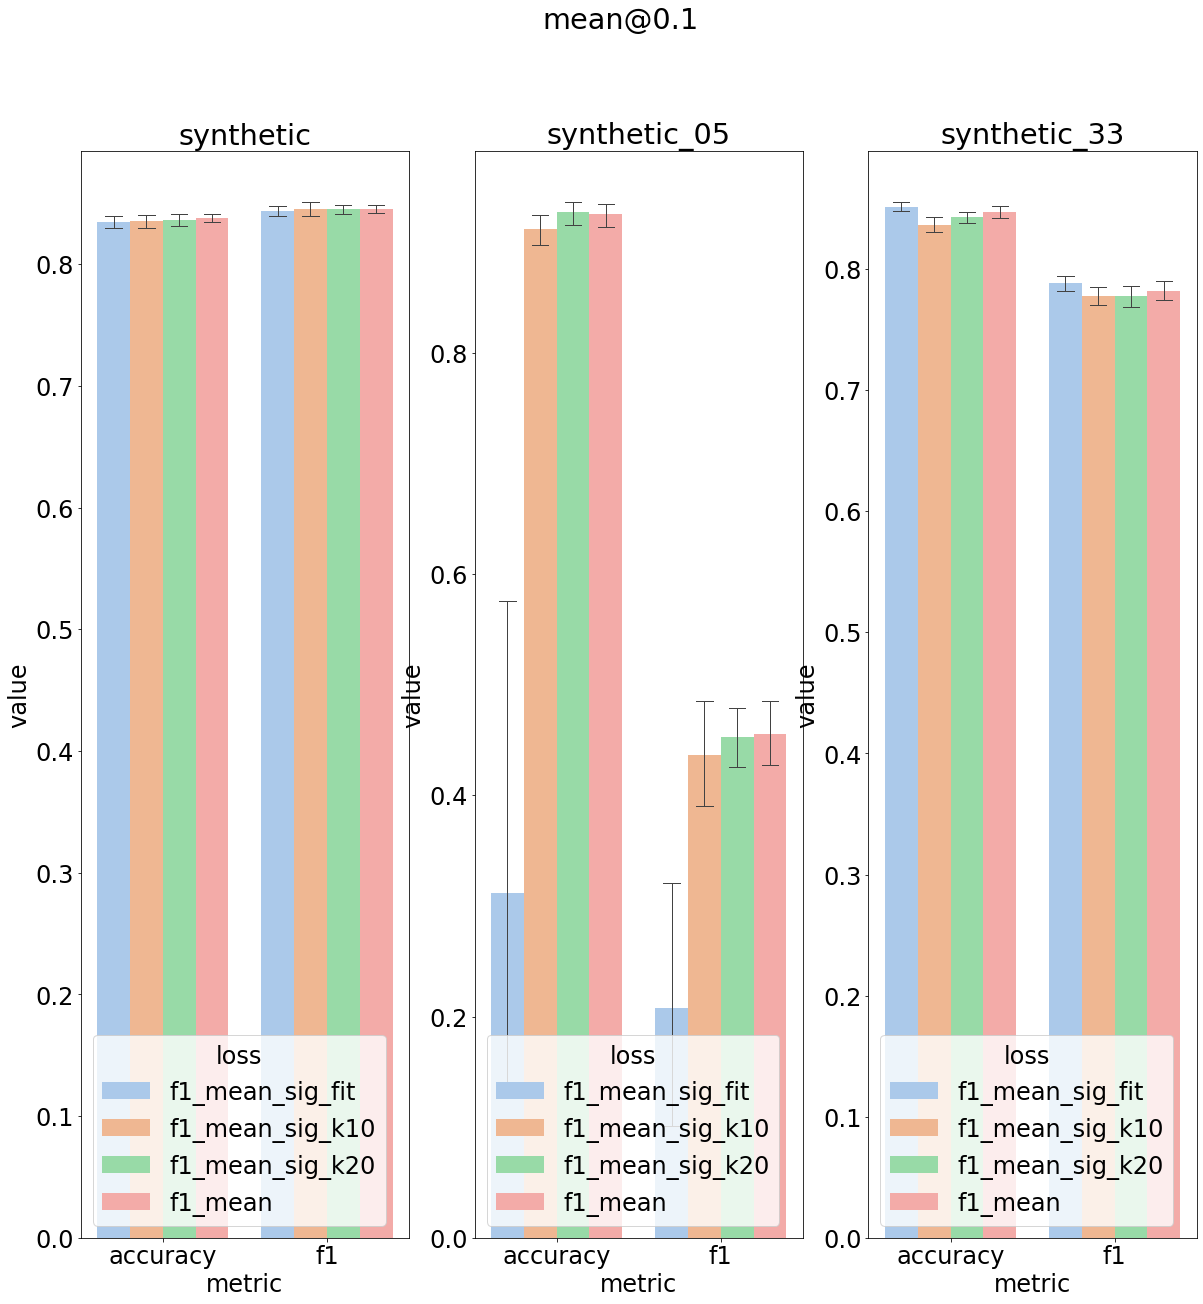

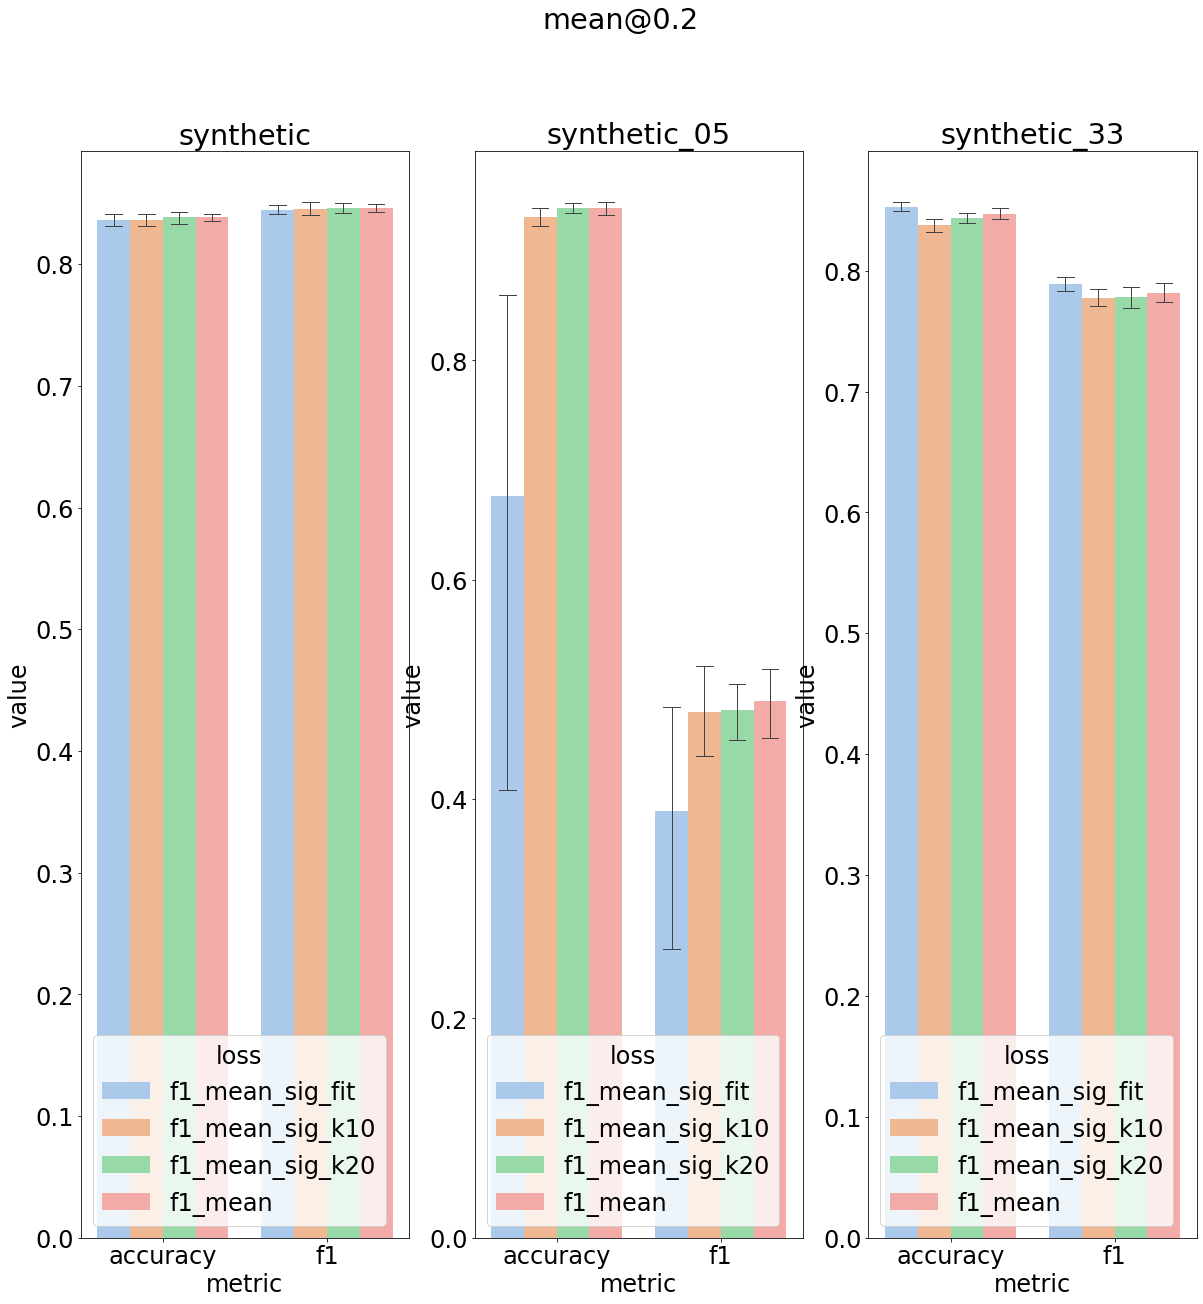

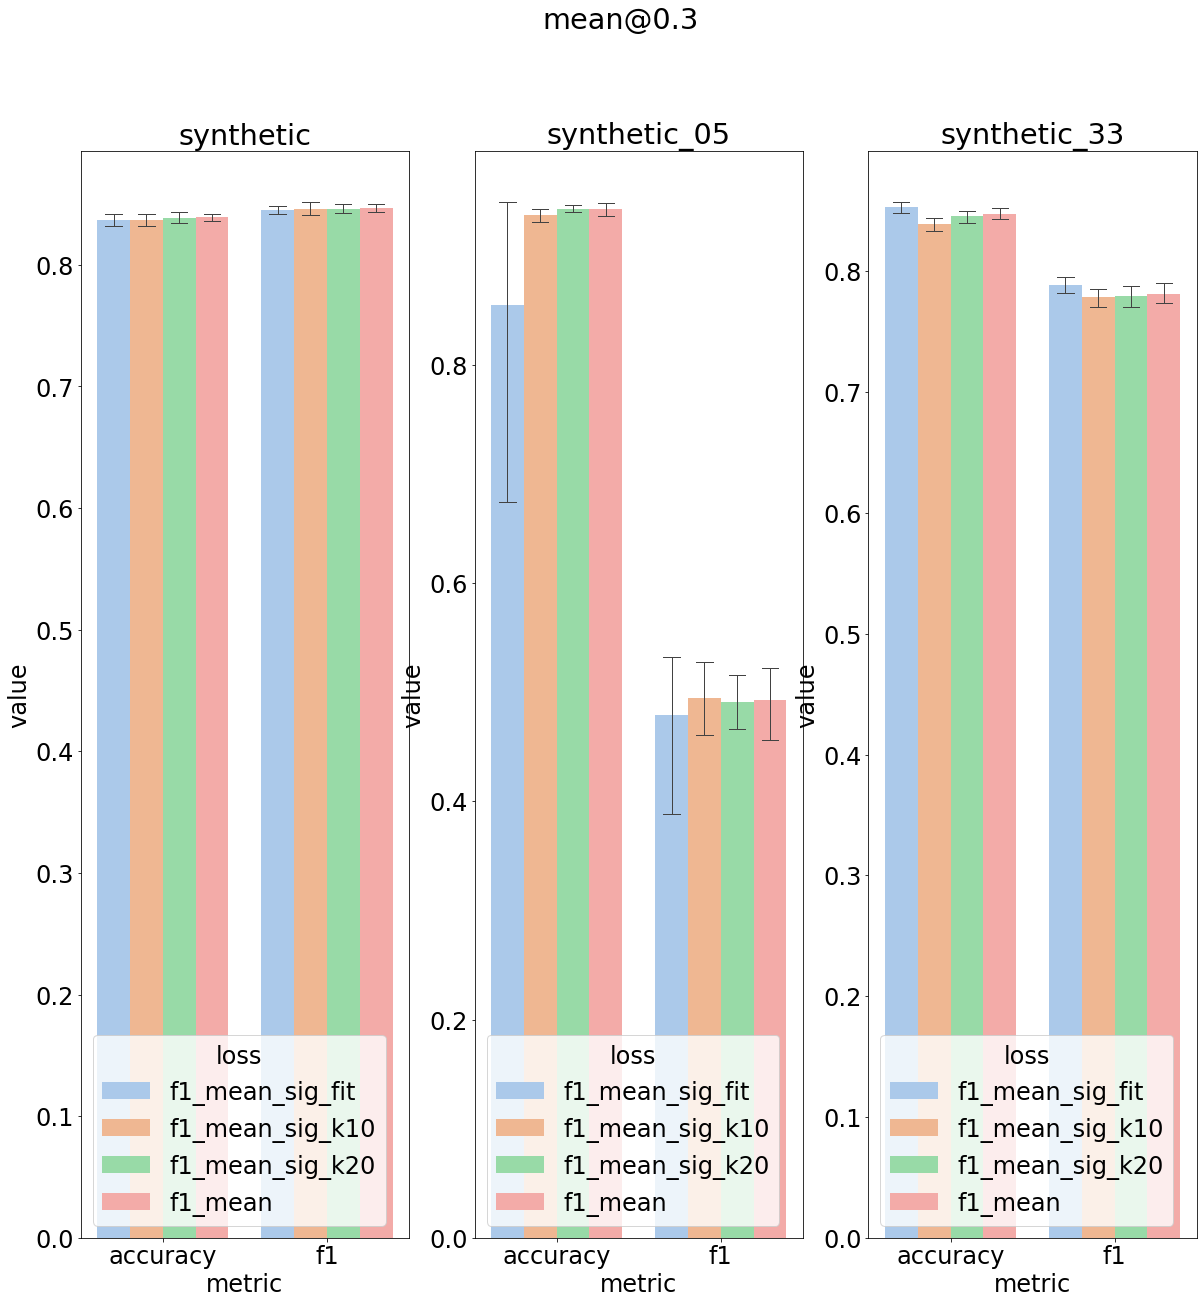

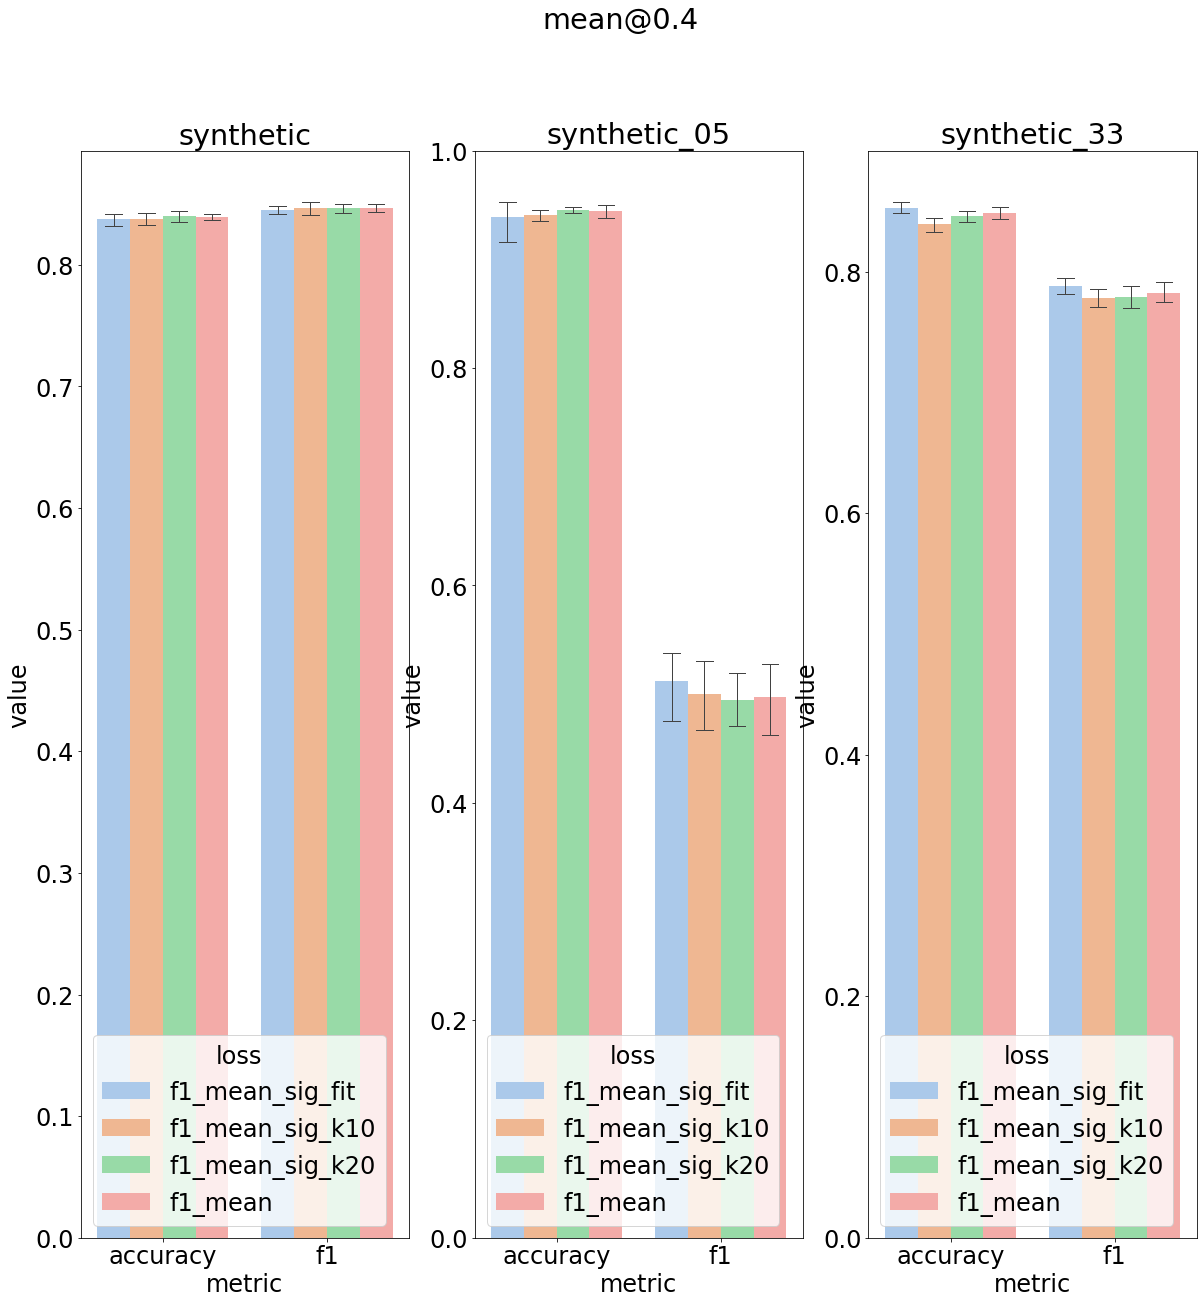

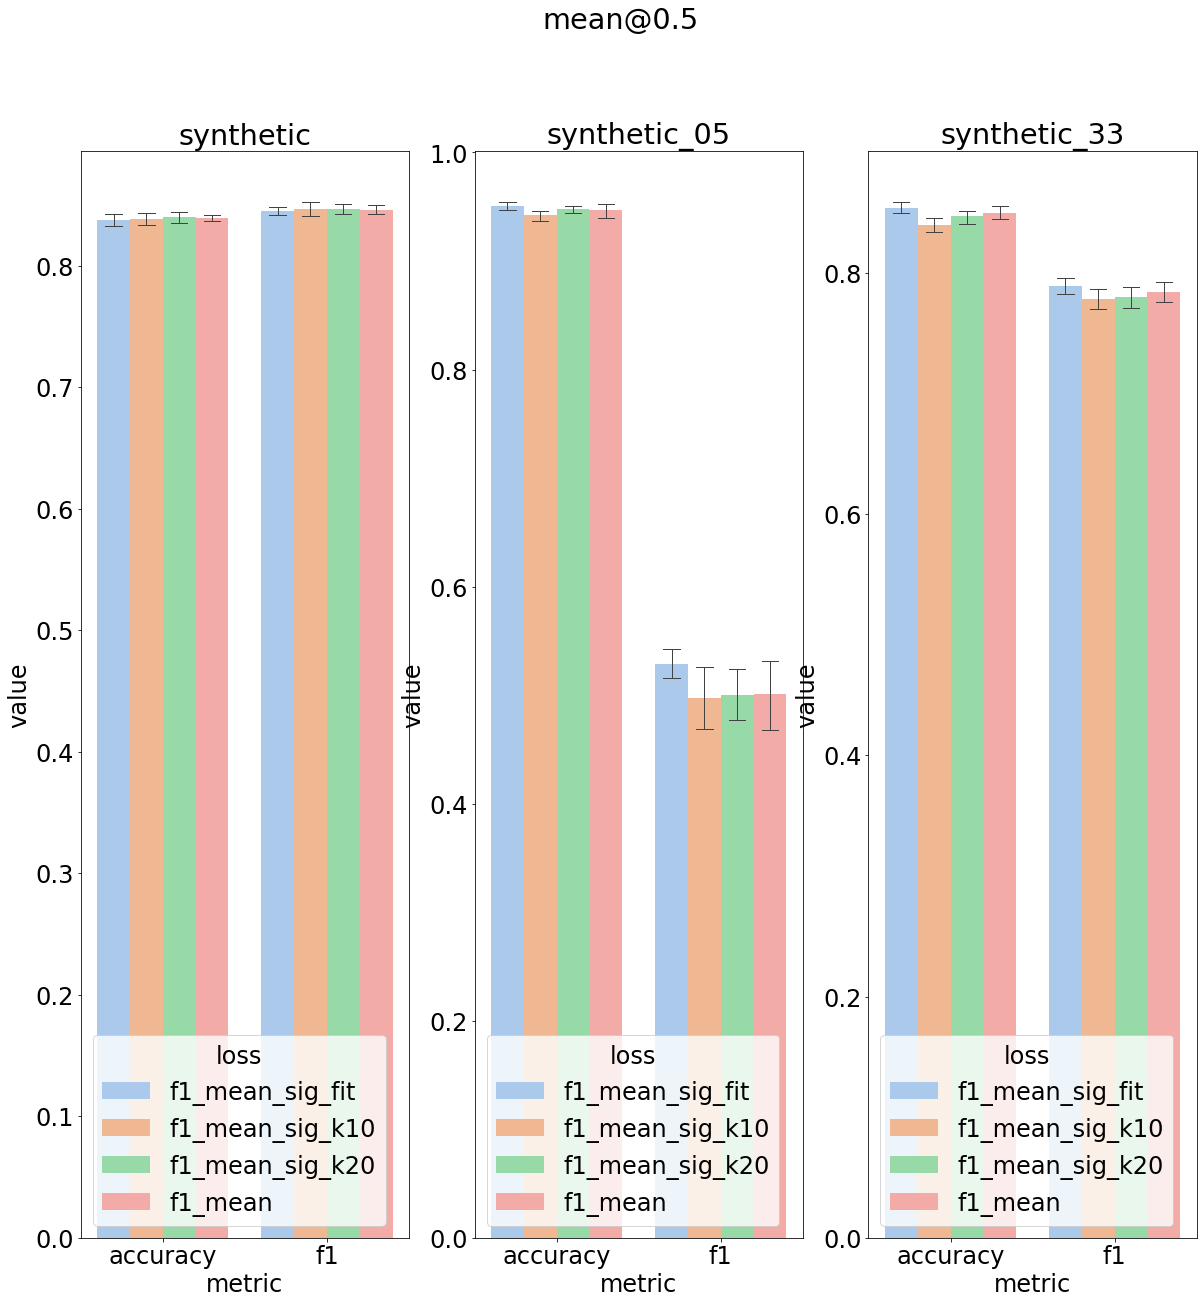

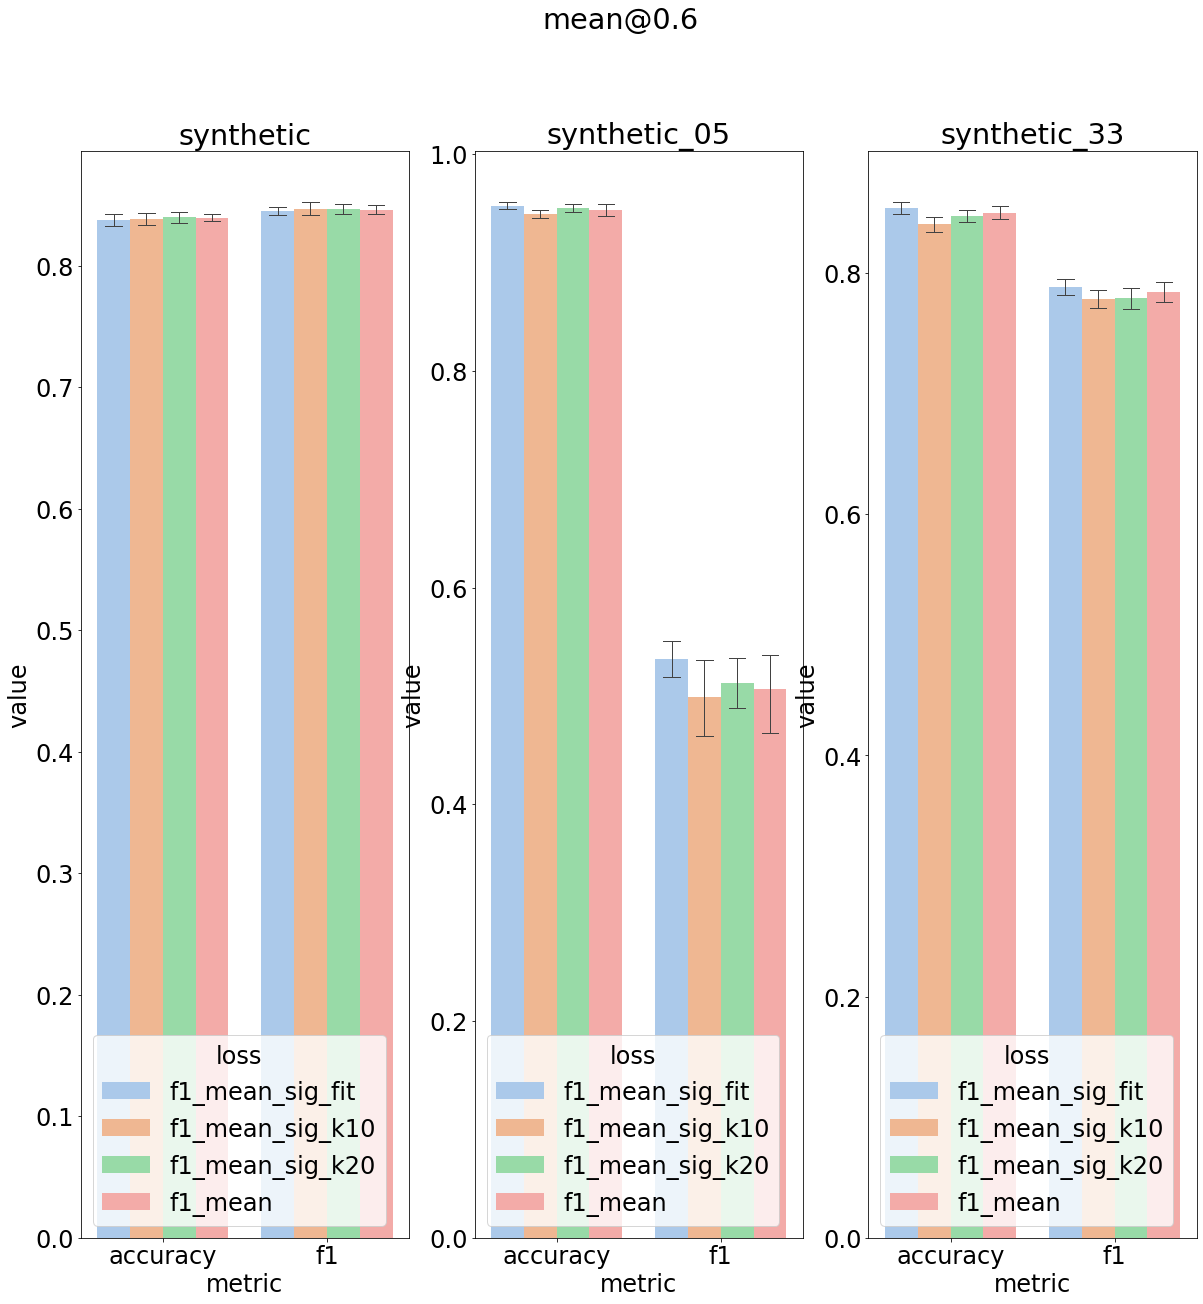

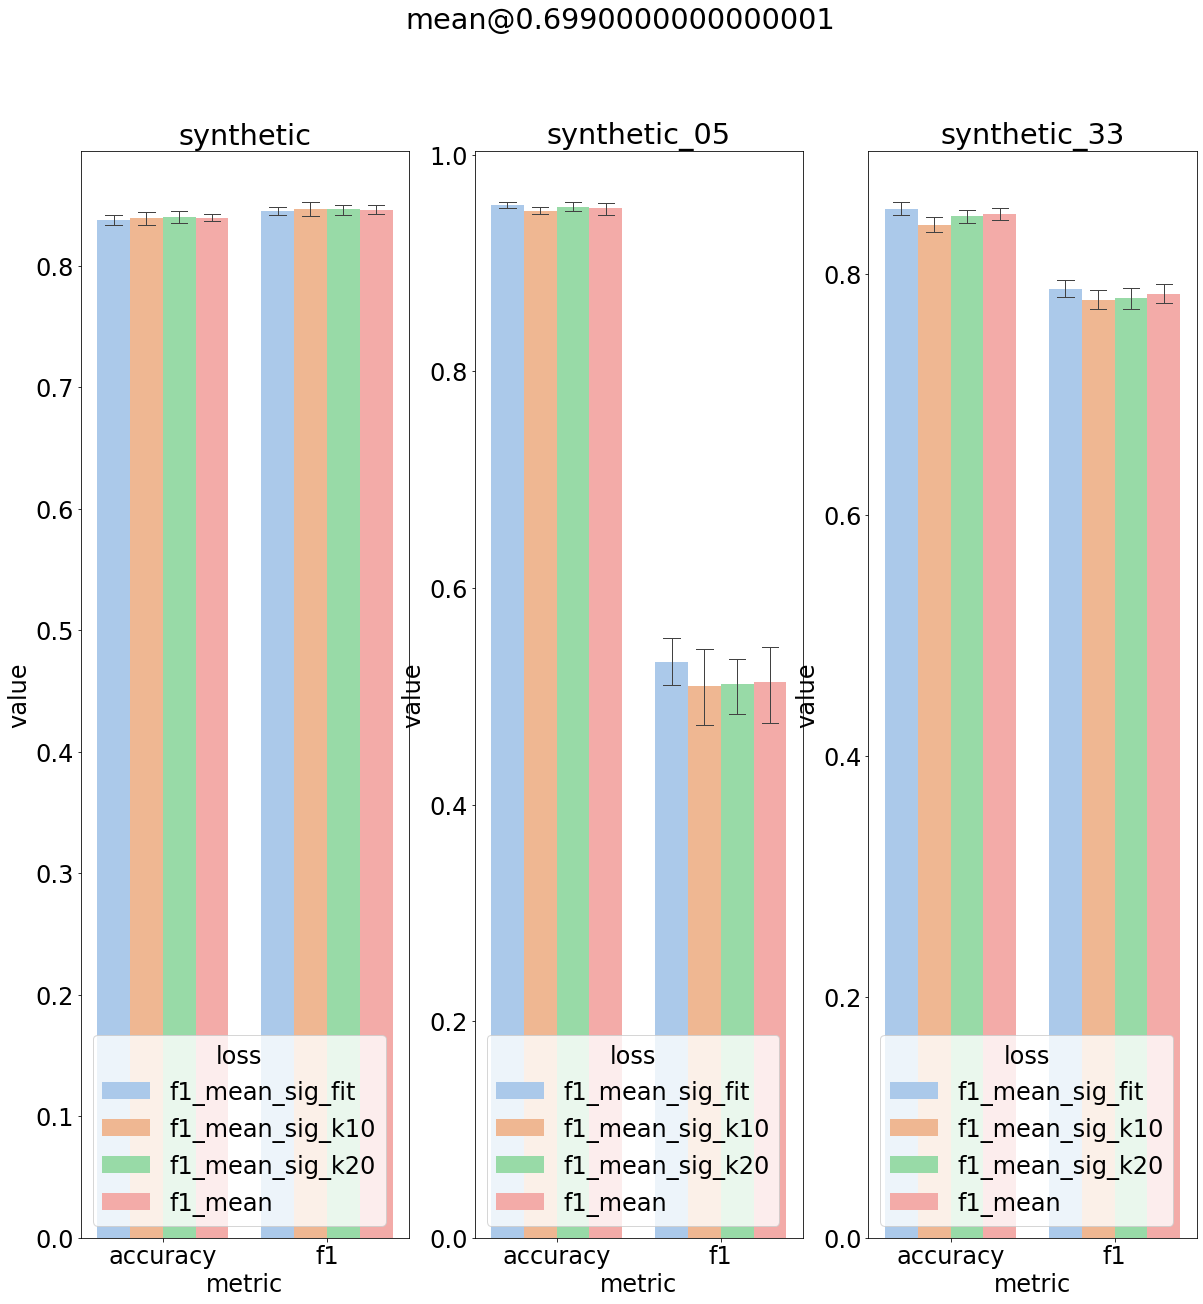

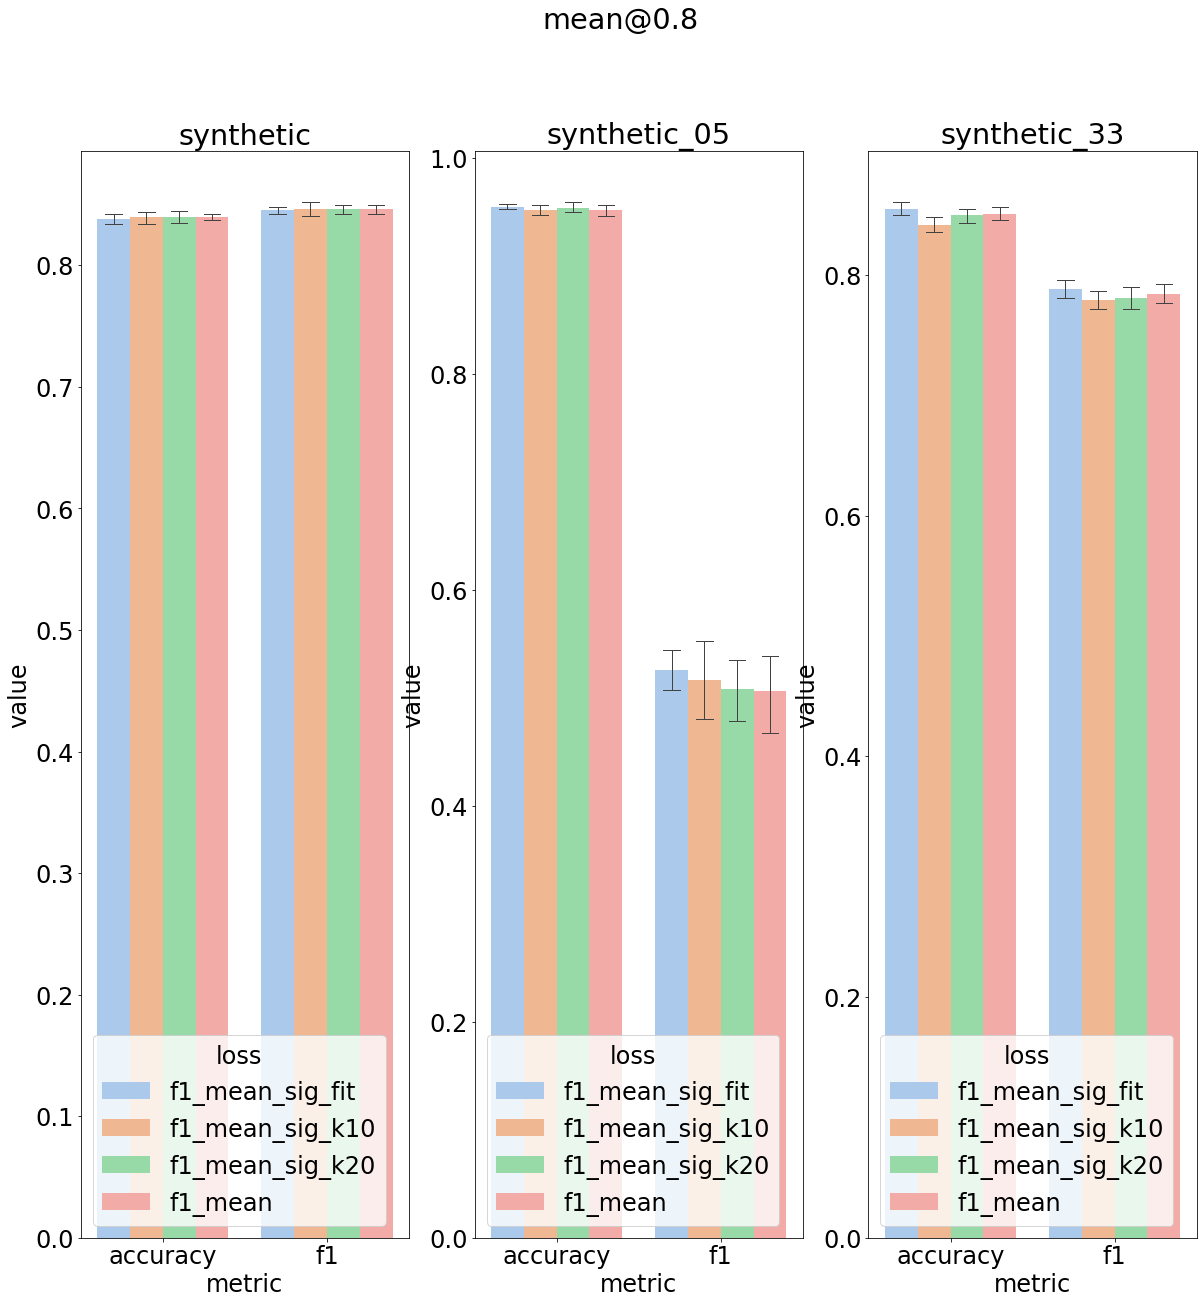

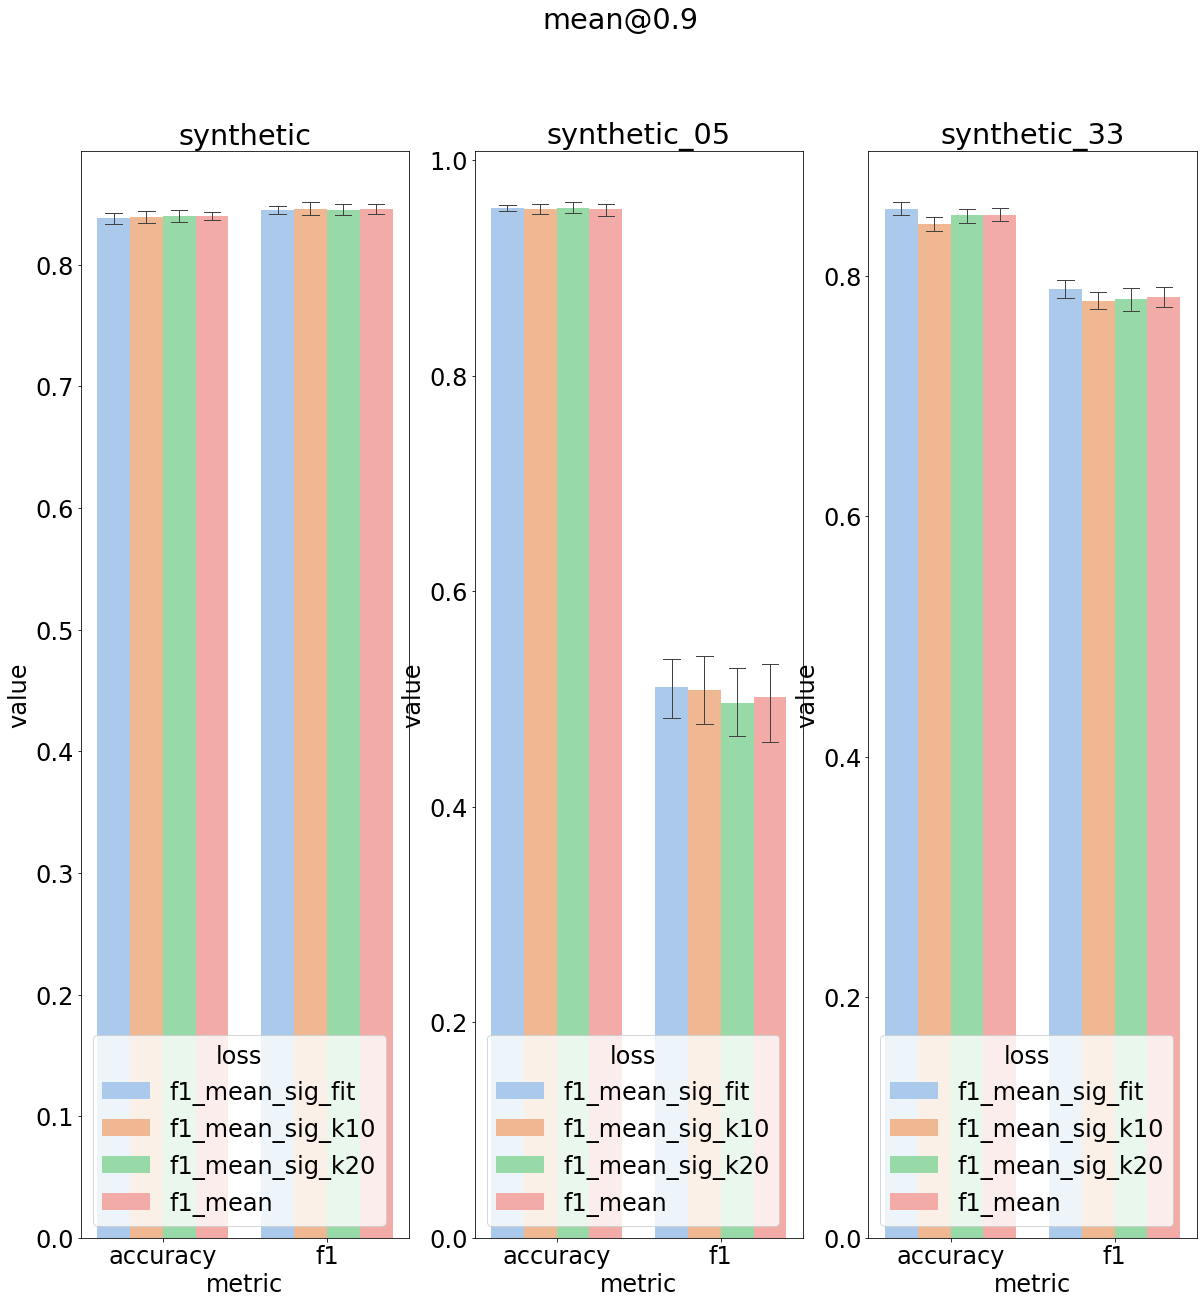

In [46]:
METRICS = ['accuracy', 'f1']
LOSSES = {
    '05': ['f1_05', 'f1_05_sig_k10', 'f1_05_sig_k20', 'f1_05_sig_fit'],
    'mean': ['f1_mean', 'f1_mean_sig_k10', 'f1_mean_sig_k20', 'f1_mean_sig_fit']
}
_df = df1p
THRESHOLDS = []
for t in np.arange(0.1,1,0.1).round(1):
    print(t)
    n = find_neighbours(_df, t)
    #print(n)
    n = list(n)[0]
    print(n)
    THRESHOLDS.append(n)
t2 = []
for t in THRESHOLDS:
    t2.append(_df.iloc[t].threshold)
THRESHOLDS = t2
print(THRESHOLDS)
for name, losses in LOSSES.items():
    for threshold in THRESHOLDS:
        fig, axs = plt.subplots(1, len(_df.dataset.unique()))
        fig.suptitle("{}@{}".format(name, threshold))
        for i, ds in enumerate(_df.dataset.unique()):
            _adf = _df[(_df["dataset"]==ds)&(_df['metric'].isin(METRICS))&(_df['loss'].isin(losses))&(_df['threshold'].isin([threshold]))]
            #print(_adf)
            if _adf.empty:
                continue
            axs[i].set_title(ds)
            sns.barplot(x="metric", y="value", data=_adf, hue="loss", capsize=.1, errwidth=1.0, ax=axs[i])
        plt.show()

# Experiment 2

Optimizing metrics based on CMVs is possible and optimal

In [47]:
EXP2 = 't52'

### Training Time

In [48]:
import glob
import datetime
for log in glob.iglob("../experiments/*/{}/experiments.log".format(EXP2)):
    pass

print("reading", log)
by_id = {}
with open(log) as f:
    for line in f.readlines():
        line = line.strip()
        if line.endswith("===START===") or line.endswith("===END==="):
            _id = line.split()[-2].split(':')[0]
            ts = datetime.datetime.strptime(' '.join(line.split()[0:2]).split(',')[0], "%Y-%m-%d %H:%M:%S")
            if _id not in by_id:
                by_id[_id] = []
            # seconds
            by_id[_id].append(ts.timestamp())
            print(ts.timestamp(), _id)

seconds_per_model = []
for _id, arr in by_id.items():
    if len(arr) != 2:
        print("Wrong number of timesteps {}, skipping".format(_id))
        continue
    seconds = abs(arr[0] - arr[1])
    models = len([f for f in glob.iglob("../experiments/*/{}/{}*/*.h5".format(EXP2,_id))])
    if models == 0:
        print("No models in {}, skipping".format(_id))
        continue
    seconds_per_model.append(seconds/models)

print("Found {} experiments".format(len(seconds_per_model)))
print("Average seconds per model: {} +/- {}".format(np.mean(seconds_per_model), np.std(seconds_per_model)))

reading ../experiments/running/t52/experiments.log
1590903289.0 20200531_053448_511801_00009
1590903289.0 20200531_053448_511801_00000
1590903289.0 20200531_053448_511801_00004
1590903289.0 20200531_053448_511801_00008
1590903289.0 20200531_053448_511801_00006
1590903289.0 20200531_053448_511801_00001
1590903289.0 20200531_053448_511801_00005
1590903289.0 20200531_053448_511801_00007
1590903289.0 20200531_053448_511801_00003
1590903289.0 20200531_053448_511801_00002
1590905867.0 20200531_053448_511801_00008
1590905987.0 20200531_053448_511801_00003
1590906070.0 20200531_053448_511801_00001
1590906106.0 20200531_053448_511801_00000
1590906216.0 20200531_053448_511801_00009
1590906230.0 20200531_053448_511801_00007
1590906419.0 20200531_053448_511801_00005
1590906449.0 20200531_053448_511801_00004
1590906534.0 20200531_053448_511801_00002
1590906590.0 20200531_053448_511801_00006
Found 10 experiments
Average seconds per model: 73.94500000000001 +/- 5.781790380150425


### Training steps per loss

does the linear approximation converge faster?

In [49]:
import glob
import datetime
for log in glob.iglob("../experiments/*/{}/experiments.log".format(EXP2)):
    pass

import re

print("reading", log)
timestamps = {'start':{}, 'end':{}}
ends = {}
with open(log) as f:
    for line in f.readlines():
        line = line.strip()
        if re.search('Fitting:', line) or re.search(' evaluation', line):
            print(line)
            _id = line.split()[-2].split(':')[0]
            if re.search('Fitting:', line):
                k = 'start'
                model = line.split('Fitting: ')[-1].split(' ')[0]
            else:
                k = 'end'
            id_model = '-'.join([_id, model])
            ts = datetime.datetime.strptime(' '.join(line.split()[0:2]).split(',')[0], "%Y-%m-%d %H:%M:%S")
            if _id not in by_id:
                by_id[_id] = []
            # seconds
            by_id[_id].append(ts.timestamp())
            print(ts.timestamp(), id_model)

print("Found {} experiments".format(len(seconds_per_model)))
print("Average seconds per model: {} +/- {}".format(np.mean(seconds_per_model), np.std(seconds_per_model)))

reading ../experiments/running/t52/experiments.log
2020-05-31 05:34:56,619 [INFO][MainThread] 20200531_053448_511801_00006: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,632 [INFO][MainThread] 20200531_053448_511801_00009: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,633 [INFO][MainThread] 20200531_053448_511801_00005: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,639 [INFO][MainThread] 20200531_053448_511801_00004: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,641 [INFO][MainThread] 20200531_053448_511801_00003: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,660 [INFO][MainThread] 20200531_053448_511801_00002: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,665 [INFO][MainThread] 20200531_053448_511801_00008: Fitting: f1_05 on synthetic
1590903296.0 on-f1_05
2020-05-31 05:34:56,689 [INFO][MainThread] 20200531_053448_511801_00007: Fitting: f1_05 

1590904597.0 test-f1_mean_sig_k10
2020-05-31 05:56:37,590 [INFO][MainThread] 20200531_053448_511801_00000: Fitting: f1_mean on synthetic_33
1590904597.0 on-f1_mean
2020-05-31 05:56:43,245 [INFO][MainThread] 20200531_053448_511801_00009: train evaluation
1590904603.0 train-f1_mean
2020-05-31 05:56:43,417 [INFO][MainThread] 20200531_053448_511801_00009: test evaluation
1590904603.0 test-f1_mean
2020-05-31 05:56:43,711 [INFO][MainThread] 20200531_053448_511801_00009: Fitting: f1_05_sig_k20 on synthetic_33
1590904603.0 on-f1_05_sig_k20
2020-05-31 05:56:50,474 [INFO][MainThread] 20200531_053448_511801_00006: train evaluation
1590904610.0 train-f1_05_sig_k20
2020-05-31 05:56:50,643 [INFO][MainThread] 20200531_053448_511801_00006: test evaluation
1590904610.0 test-f1_05_sig_k20
2020-05-31 05:56:50,937 [INFO][MainThread] 20200531_053448_511801_00006: Fitting: f1_05_sig_k10 on synthetic_33
1590904610.0 on-f1_05_sig_k10
2020-05-31 05:57:17,160 [INFO][MainThread] 20200531_053448_511801_00001: tra

2020-05-31 06:01:36,105 [INFO][MainThread] 20200531_053448_511801_00006: Fitting: f1_mean_sig_fit on synthetic_33
1590904896.0 on-f1_mean_sig_fit
2020-05-31 06:01:37,891 [INFO][MainThread] 20200531_053448_511801_00009: train evaluation
1590904897.0 train-f1_mean_sig_fit
2020-05-31 06:01:38,057 [INFO][MainThread] 20200531_053448_511801_00009: test evaluation
1590904898.0 test-f1_mean_sig_fit
2020-05-31 06:01:38,342 [INFO][MainThread] 20200531_053448_511801_00009: Fitting: f1_mean_sig_k20 on synthetic_33
1590904898.0 on-f1_mean_sig_k20
2020-05-31 06:02:00,306 [INFO][MainThread] 20200531_053448_511801_00000: train evaluation
1590904920.0 train-f1_mean_sig_k20
2020-05-31 06:02:00,495 [INFO][MainThread] 20200531_053448_511801_00000: test evaluation
1590904920.0 test-f1_mean_sig_k20
2020-05-31 06:02:00,805 [INFO][MainThread] 20200531_053448_511801_00000: Fitting: accuracy_05 on synthetic_33
1590904920.0 on-accuracy_05
2020-05-31 06:02:03,231 [INFO][MainThread] 20200531_053448_511801_00003: t

## sklearn results

no divide-by-zero handling!

computed after training via sklearn

In [50]:
df2 = load_final(EXP2)

looking for ../experiments/*/t52/*/*_test_final.pkl
loading 390 pkls


In [51]:
df2.loss.unique()

array(['f1_mean_sig_fit', 'f1_05_sig_k20', 'f1_mean_sig_k10', 'f1_05',
       'f1_05_sig_fit', 'f1_05_sig_k10', 'f1_mean_sig_k20', 'roc',
       'accuracy_05', 'f3_05', 'bce', 'f2_05', 'f1_mean'], dtype=object)

In [52]:
df2.dataset.unique()

array(['synthetic', 'synthetic_05', 'synthetic_33'], dtype=object)

In [53]:
#TODO: ROC?
# 'bce', 'mse', 
DATASETS = ['cocktailparty', 'uci_adult', 'mammography', 'kaggle_cc_fraud', 'winequality']
#LOSSES = ['accuracy', 'f1_mean', 'accuracy_05', 'f1_05', 'roc', 'bce']#'accuracy','f1_mean'
LOSSES = df2.loss.unique()
METRICS = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
cols = ['experiment_id', 'dataset', 'loss', 'metric', 'value', 'threshold']
# max over thresholds we train on
THRESHOLDS =  np.arange(0.1, 1, 0.1)
# one threshold to avoid search problem
#THRESHOLDS = [0.5]
df_dict = {}
for col in cols:
    df_dict[col] = []
for ds in DATASETS:
    for loss in LOSSES:
        # array of metric values across trials
#        for threshold in THRESHOLDS:
#             _df = df2[(df2['dataset']==ds)&(df2['loss']==loss)&(df2['threshold']==threshold)]    
#             for metric in METRICS:
#                 df_dict['loss'].append(loss)
#                 df_dict['dataset'].append(ds)
#                 df_dict['metric'].append(metric)
#                 df_dict['threshold'].append(threshold)
#                 df_dict['value'].append(_df[metric].max())
        for metric in METRICS:
            for i, row in df2[(df2['dataset']==ds)&(df2['loss']==loss)&(df2['threshold'].isin(THRESHOLDS))].iterrows():
            #for i, row in df2[(df2['dataset']==ds)&(df2['loss']==loss)].iterrows():
                df_dict['experiment_id'].append(row.experiment_id)
                df_dict['loss'].append(loss)
                df_dict['dataset'].append(ds)
                df_dict['metric'].append(metric)
                df_dict['threshold'].append(row.threshold)
                df_dict['value'].append(row[metric])
df2p = pd.DataFrame.from_dict(df_dict)

In [54]:
df2p

,experiment_id,dataset,loss,metric,value,threshold


### TODO: Experiment 3 plots

In [55]:
df2p.metric.unique()

array([], dtype=float64)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


<AxesSubplot:xlabel='threshold', ylabel='value'>

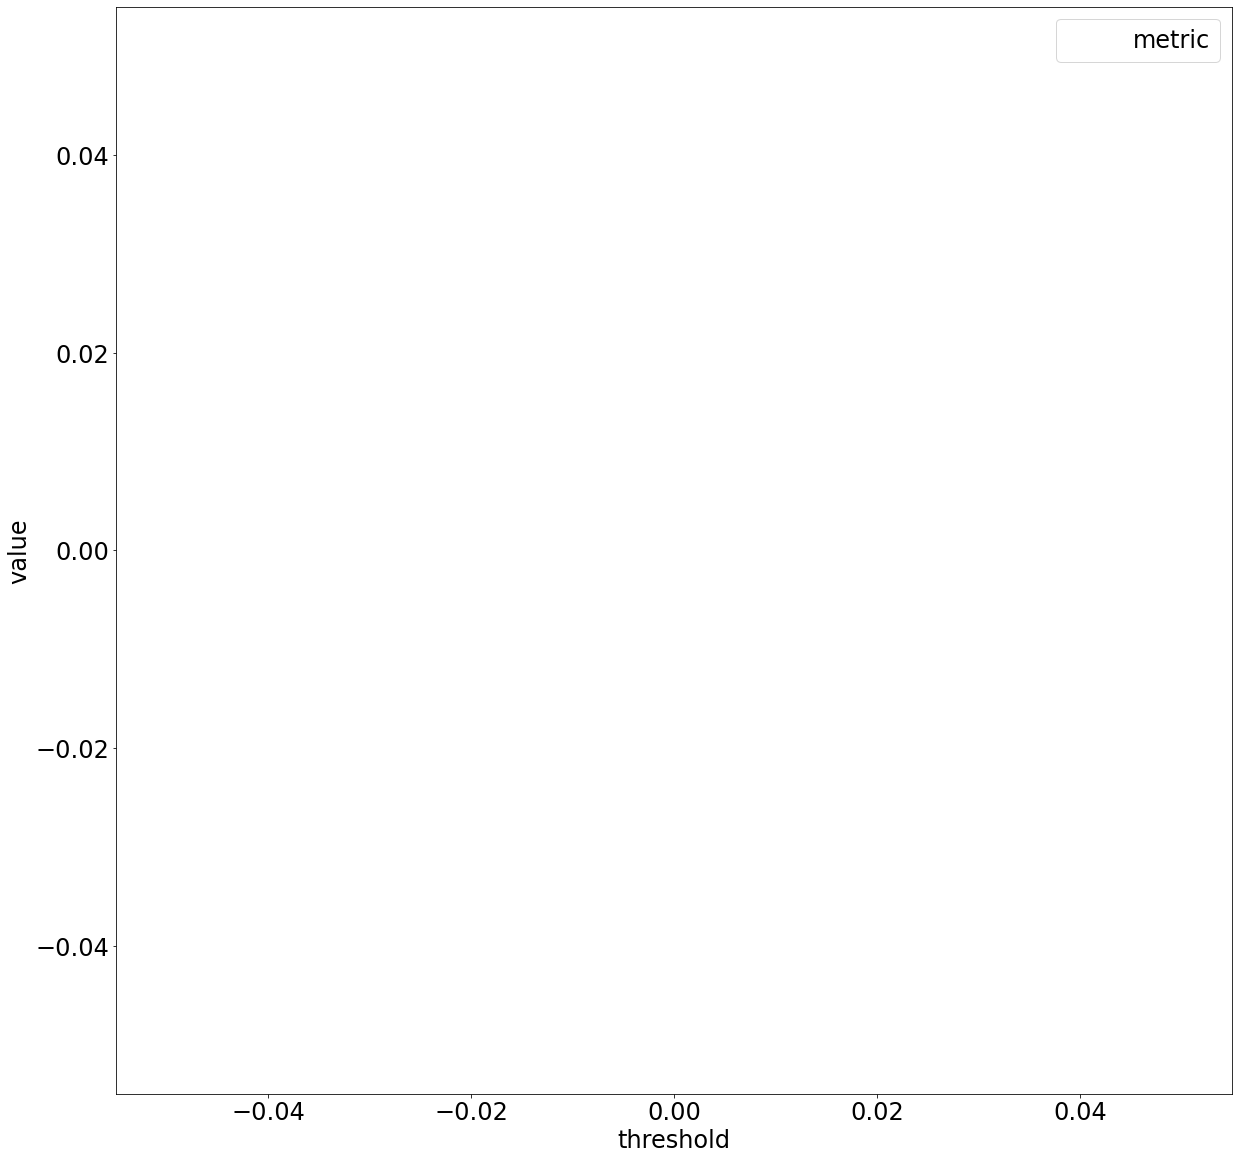

In [56]:
_df = df2p[(df2p['dataset']=='uci_adult')&(df2p['metric'].isin(['f1', 'precision', 'recall']))]
sns.lineplot(x='threshold', y='value', data=_df, hue='metric')

### SKlearn Tabular compute max over all thresholds per experiment

In [57]:
df2pg = df2p.groupby(["experiment_id", "dataset", "loss", "metric"])
df_dict = {}
# aggregate max over thresholds per experiment
cols = ['dataset', 'loss', 'metric', 'value', 'threshold']
for col in cols:
    df_dict[col] = []
for name, group in df2pg:
    maxidx = group['value'].idxmax() - group.iloc[0].name
    maxrow = group.iloc[maxidx]
    df_dict['loss'].append(maxrow.loss)
    df_dict['dataset'].append(maxrow.dataset)
    df_dict['metric'].append(maxrow.metric)
    df_dict['value'].append(maxrow.value)
    df_dict['threshold'].append(maxrow.threshold)
    
df2pmax = pd.DataFrame.from_dict(df_dict)

In [58]:
df2pmax

,dataset,loss,metric,value,threshold


In [59]:
df2pmax.loss.unique()

array([], dtype=float64)

In [60]:
df2p.loss.unique()

array([], dtype=float64)

In [61]:
df2p.metric.unique()

array([], dtype=float64)

### Sklearn mean table

In [62]:
D = DATASETS
L = ['accuracy_05', 'f1_05', 'roc', 'bce']
M = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
_df = df2p
# one table per dataset
for ds in D:
    print(ds)
    rows = [','.join(M)]
    for loss in L:
        print("LOSS:", loss)
        row = [loss]
        for metric in M:
            r = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)]
            #print(r)
            threshold = r['threshold'].median()
            mean = r.value.mean()
            std = r.value.std()
            print("MEAN METRIC ({}): {:.03f} +/- {:.02f} @ {}".format(metric, mean, std, threshold))
            row.append("${:.03f} \pm {:.02f}$".format(mean, std))
        rows.append(','.join(row))
    print("--- copy {} ---".format(ds))
    print("\n".join(rows))

cocktailparty
LOSS: accuracy_05
MEAN METRIC (accuracy): nan +/- nan @ nan
MEAN METRIC (f1): nan +/- nan @ nan
MEAN METRIC (roc_auc): nan +/- nan @ nan
MEAN METRIC (precision): nan +/- nan @ nan
MEAN METRIC (recall): nan +/- nan @ nan
LOSS: f1_05
MEAN METRIC (accuracy): nan +/- nan @ nan
MEAN METRIC (f1): nan +/- nan @ nan
MEAN METRIC (roc_auc): nan +/- nan @ nan
MEAN METRIC (precision): nan +/- nan @ nan
MEAN METRIC (recall): nan +/- nan @ nan
LOSS: roc
MEAN METRIC (accuracy): nan +/- nan @ nan
MEAN METRIC (f1): nan +/- nan @ nan
MEAN METRIC (roc_auc): nan +/- nan @ nan
MEAN METRIC (precision): nan +/- nan @ nan
MEAN METRIC (recall): nan +/- nan @ nan
LOSS: bce
MEAN METRIC (accuracy): nan +/- nan @ nan
MEAN METRIC (f1): nan +/- nan @ nan
MEAN METRIC (roc_auc): nan +/- nan @ nan
MEAN METRIC (precision): nan +/- nan @ nan
MEAN METRIC (recall): nan +/- nan @ nan
--- copy cocktailparty ---
accuracy,f1,roc_auc,precision,recall
accuracy_05,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm n

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning:

### Sklearn max table

In [63]:
D = DATASETS
L = ['accuracy_05', 'f1_05', 'roc', 'bce']
M = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall']
_df = df2pmax
# one table per dataset
for ds in D:
    print(ds)
    rows = [','.join(M)]
    for loss in L:
        print("LOSS:", loss)
        row = [loss]
        for metric in M:
            r = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)]
            #print(r)
            threshold = r['threshold'].median()
            mean = r.value.mean()
            std = r.value.std()
            print("MAX METRIC ({}): {:.03f} +/- {:.02f} @ {}".format(metric, mean, std, threshold))
            row.append("${:.03f} \pm {:.02f}$".format(mean, std))
        rows.append(','.join(row))
    print("--- copy {} ---".format(ds))
    print("\n".join(rows))

cocktailparty
LOSS: accuracy_05
MAX METRIC (accuracy): nan +/- nan @ nan
MAX METRIC (f1): nan +/- nan @ nan
MAX METRIC (roc_auc): nan +/- nan @ nan
MAX METRIC (precision): nan +/- nan @ nan
MAX METRIC (recall): nan +/- nan @ nan
LOSS: f1_05
MAX METRIC (accuracy): nan +/- nan @ nan
MAX METRIC (f1): nan +/- nan @ nan
MAX METRIC (roc_auc): nan +/- nan @ nan
MAX METRIC (precision): nan +/- nan @ nan
MAX METRIC (recall): nan +/- nan @ nan
LOSS: roc
MAX METRIC (accuracy): nan +/- nan @ nan
MAX METRIC (f1): nan +/- nan @ nan
MAX METRIC (roc_auc): nan +/- nan @ nan
MAX METRIC (precision): nan +/- nan @ nan
MAX METRIC (recall): nan +/- nan @ nan
LOSS: bce
MAX METRIC (accuracy): nan +/- nan @ nan
MAX METRIC (f1): nan +/- nan @ nan
MAX METRIC (roc_auc): nan +/- nan @ nan
MAX METRIC (precision): nan +/- nan @ nan
MAX METRIC (recall): nan +/- nan @ nan
--- copy cocktailparty ---
accuracy,f1,roc_auc,precision,recall
accuracy_05,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$
f1

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:68: FutureWarning:

### SKLearn Plots

In [64]:
METRICS = ['accuracy', 'f1', 'roc_auc']
LOSSES = ['accuracy_05', 'f1_05', 'roc', 'bce']
for ds in _df.dataset.unique():
    print(ds)
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    df_max = df2pmax[(df2pmax["dataset"]==ds)&(df2pmax['metric'].isin(METRICS))&(df2pmax['loss'].isin(LOSSES))].sort_values(['loss', 'metric'])
    print(df_max)
    df_mean = df2p[(df2p["dataset"]==ds)&(df2p['metric'].isin(METRICS))&(df2p['loss'].isin(LOSSES))].sort_values(['loss', 'metric'])
    plt.suptitle("{} max".format(ds))
    sns.barplot(x="metric", y="value", data=df_max, hue="loss", capsize=.1, errwidth=1.0, palette="deep")
    plt.show()
    plt.suptitle("{} mean".format(ds))
    sns.barplot(x="metric", y="value", data=df_mean, hue="loss", capsize=.1, errwidth=1.0, palette="deep")
    plt.show()

## TF results
computed with the same metric code as during training, after training is complete (via tensorflow)

In [65]:
dfr2 = load_results(EXP2)
print("metrics:", dfr2.metric.unique())
print("losses:", dfr2.loss.unique())
dfr2

looking for ../experiments/*/t52/*/experiment.pkl
loading 10 pkls
metrics: ['loss' 'tp' 'fp' 'tn' 'fn' 'accuracy' 'precision' 'recall' 'roc_auc'
 'pr_auc' 'f1' 'f1_mean' 'f1_max' 'tpr' 'fpr']
losses: ['f1_05' 'f1_05_sig_k10' 'f1_05_sig_k20' 'f1_05_sig_fit' 'f1_mean'
 'f1_mean_sig_k10' 'f1_mean_sig_k20' 'f1_mean_sig_fit' 'bce' 'roc'
 'accuracy_05' 'f2_05' 'f3_05']


,dataset,loss,split,metric,value
0,synthetic,f1_05,train,loss,0.154429
1,synthetic,f1_05,train,tp,2851.000000
2,synthetic,f1_05,train,fp,671.000000
3,synthetic,f1_05,train,tn,2519.000000
4,synthetic,f1_05,train,fn,359.000000
...,...,...,...,...,...
11695,synthetic_05,f3_05,test,f1,0.377778
11696,synthetic_05,f3_05,test,f1_mean,0.369925
11697,synthetic_05,f3_05,test,f1_max,0.384181
11698,synthetic_05,f3_05,test,tpr,0.253731


In [66]:
# checking if these even exists
# they do, they're just very, very small
#dfr2[(dfr2['metric']=='f1_mean')&(dfr2['dataset']=='kaggle_cc_fraud')&(dfr2['loss']=='accuracy')]

### Select DF

In [67]:
_METRICS = list(set(METRICS+['f1', 'roc_auc'])-set(['precision','recall','pr_auc']))
_LOSSES = list(set(LOSSES+['roc', 'bce', 'mse'])-set(['pr_auc_mean']))
_df = dfr2[dfr2.split.isin(['test'])&dfr2.metric.isin(_METRICS)&dfr2.loss.isin(_LOSSES)]

In [68]:
_df.metric.unique()

array(['accuracy', 'roc_auc', 'f1'], dtype=object)

In [69]:
_df

,dataset,loss,split,metric,value
20,synthetic,f1_05,test,accuracy,0.843500
23,synthetic,f1_05,test,roc_auc,0.850284
25,synthetic,f1_05,test,f1,0.850024
260,synthetic,bce,test,accuracy,0.841500
263,synthetic,bce,test,roc_auc,0.919309
...,...,...,...,...,...
11603,synthetic_05,roc,test,roc_auc,0.898168
11605,synthetic_05,roc,test,f1,0.323529
11630,synthetic_05,accuracy_05,test,accuracy,0.956190
11633,synthetic_05,accuracy_05,test,roc_auc,0.500000


### Tabular Results

In [70]:
D = ['uci_adult', 'mammography', 'kaggle_cc_fraud', 'winequality']
L = ['accuracy_05', 'roc', 'f1_mean_05', 'bce', 'mse']
M = ['accuracy', 'roc_auc', 'f1']
rows = []
for loss in L:
    print("LOSS:", loss)
    row = []
    for ds in D:
        print("DATASET:", ds)
        for metric in M:
            print("METRIC:", metric)
            v = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)].value
            row.append(v.mean())
            row.append(v.std())
    row = ','.join(["{:.03f}".format(x) for x in row])
    print(row)
    rows.append(row)

print("--- copy ---")
print("\n".join(rows))

LOSS: accuracy_05
DATASET: uci_adult
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: mammography
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: kaggle_cc_fraud
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: winequality
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LOSS: roc
DATASET: uci_adult
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: mammography
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: kaggle_cc_fraud
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: winequality
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LOSS: f1_mean_05
DATASET: uci_adult
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: mammography
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: kaggle_cc_fraud
METRIC: accuracy
METRIC: roc_auc
METRIC: f1
DATASET: winequality
METRIC: accuracy
METR

### Plots

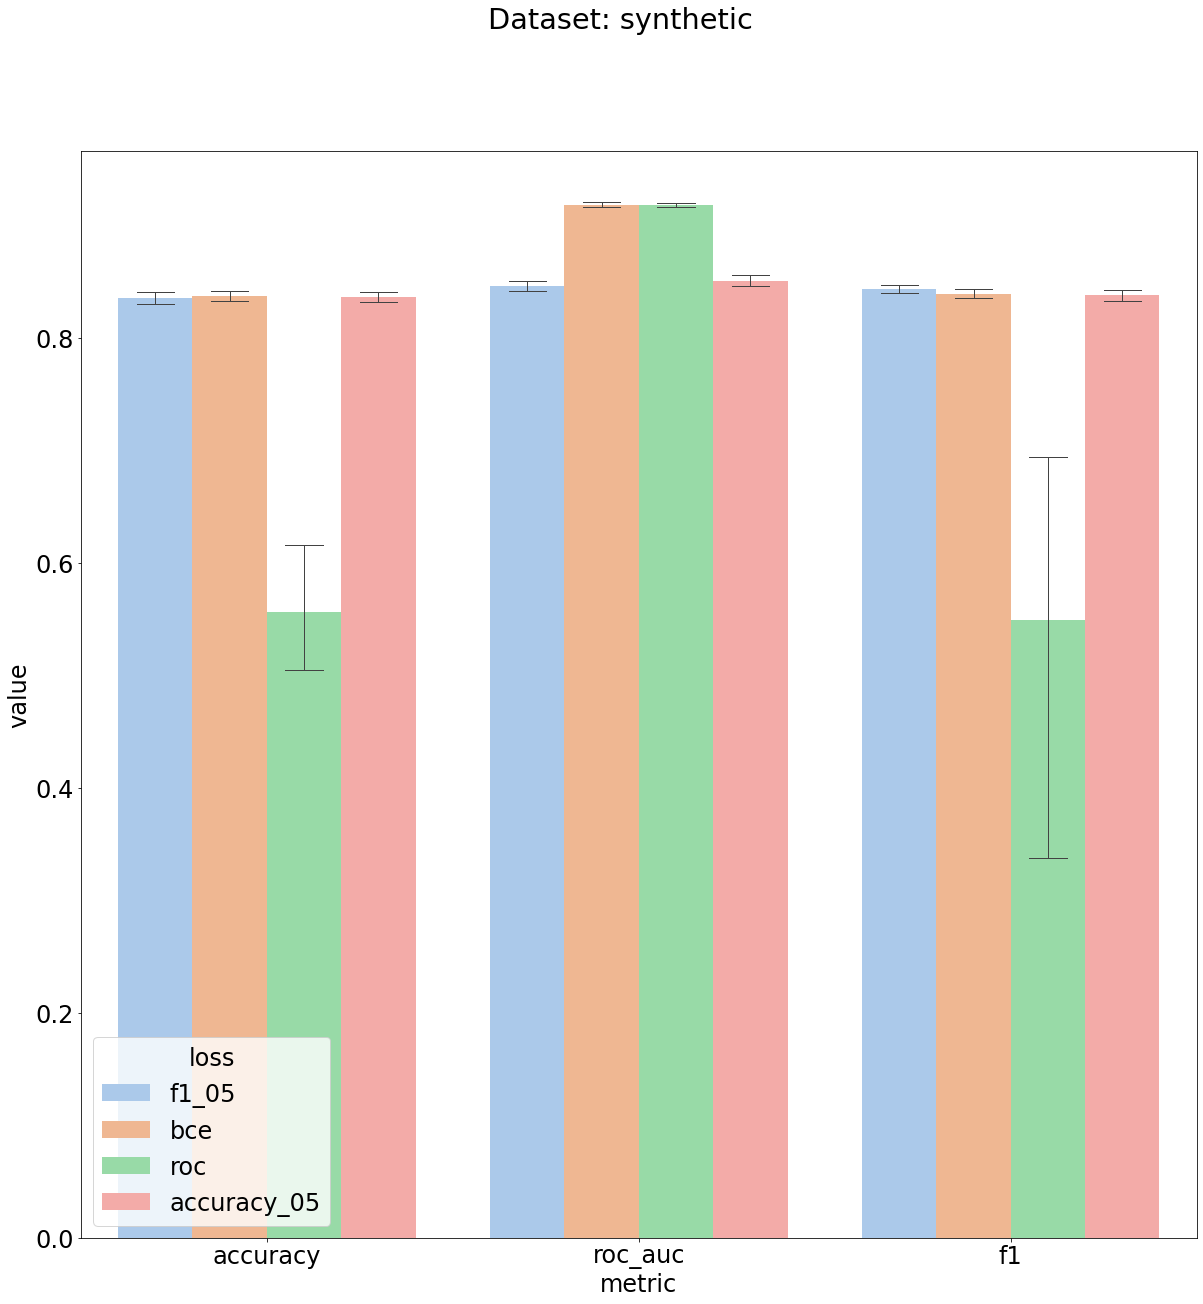

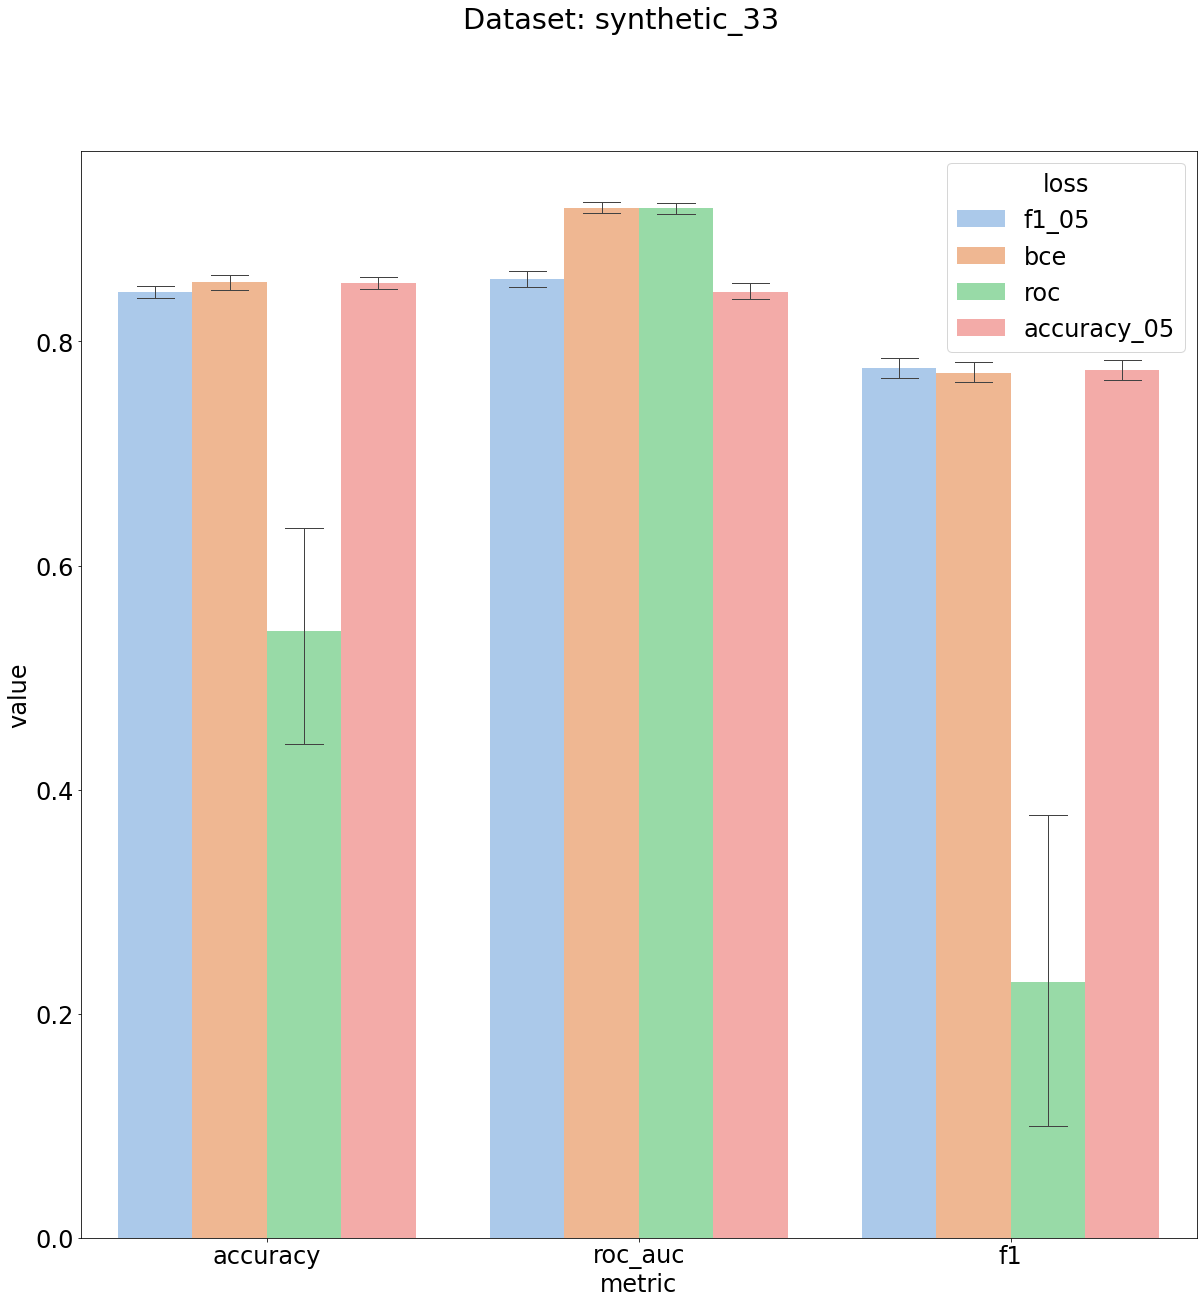

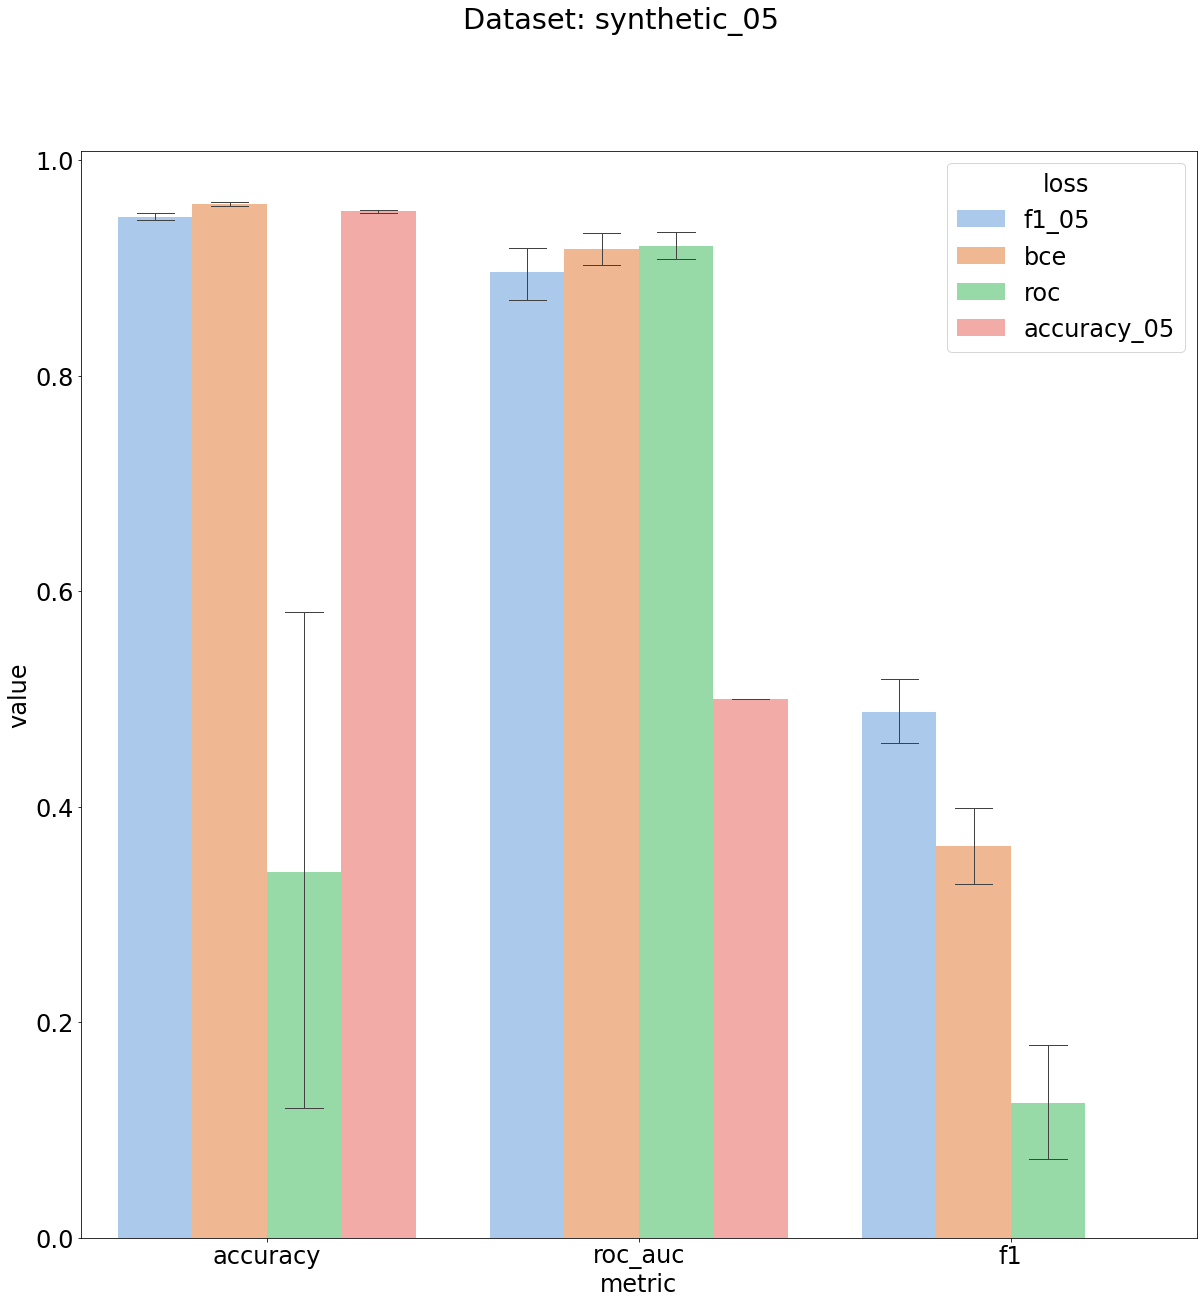

In [71]:
for ds in _df.dataset.unique():
    _df2 = _df[_df["dataset"]==ds]
    plt.figure()
    plt.suptitle("Dataset: {}".format(ds))
    sns.barplot(x="metric", y="value", data=_df2, hue="loss", capsize=.1, errwidth=1.0)
    plt.show()

In [72]:
_METRICS = ['tpr', 'fpr']
_LOSSES = ['tpr', 'fpr']
_DATASETS = ['mammography', 'uci_adult', 'kaggle_cc_fraud']
_df = dfr2[dfr2.split.isin(['test'])&dfr2.metric.isin(_METRICS)&dfr2.loss.isin(_LOSSES)&dfr2.dataset.isin(_DATASETS)]
for metric in _df.metric.unique():
    plt.figure()
    plt.suptitle("Metric: {}".format(metric))
    sns.barplot(x="dataset", y="value", data=_df[_df['metric']==metric], hue="loss", capsize=.1, errwidth=1.0)
    plt.ylabel(metric)
    plt.show()

In [73]:
# _df1 = dfr2[dfr2.split.isin(['test'])]
# for ds in _df1.dataset.unique():
#     for loss in ['tpr', 'fpr']:
#         df_dict = {'dataset': [], 'loss': [], 'split': [], 'tp': [], 'fp': [], 'tn': [], 'fn': []}
#         fig, ax = plt.subplots()
#         dfar = _df1[(_df1['dataset']==ds)&(_df1['loss']==loss)]
#         print(ds, metric, loss)
#         #print(dfar[dfar.value.isin([np.nan])])
#         df_dict['dataset'].append(dfar.dataset)
#         df_dict['loss'].append(dfar.loss)
#         df_dict['split'].append(dfar.split)
#         for m in ['tp', 'fp', 'tn', 'fn']:
#             print(ds, metric, loss, m, dfar[dfar['metric']==m].value.mean())
#             df_dict[m].append(dfar[dfar['metric']==m].value.mean())
#         _df = pd.DataFrame.from_dict(df_dict)
#         #print(_df1)
#         cm_from_df(ax, _df, name="{}: {}".format(ds, loss))

# Experiment 3

Choosing an optimization target with a goal such as balancing between output distribution precision and recall over a range of thresholds, such as F1 mean.

In [74]:
#EXP3 = 't44'
EXP3 = EXP2

In [75]:
df3 = load_final(EXP3)
df3

looking for ../experiments/*/t52/*/*_test_final.pkl
loading 390 pkls


,dataset,loss,threshold,f1,accuracy,precision,recall,ap,pr_auc,roc_auc,tpr,fpr,tn,fp,fn,tp,experiment_id
1,synthetic,f1_mean_sig_fit,0.001,0.834480,0.819500,0.771841,0.908184,0.746973,0.757237,0.819322,0.771841,0.555217,729,269,92,910,1
2,synthetic,f1_mean_sig_fit,0.002,0.834943,0.820500,0.774084,0.906188,0.748465,0.759017,0.820328,0.774084,0.553321,733,265,94,908,1
3,synthetic,f1_mean_sig_fit,0.003,0.835711,0.821500,0.775406,0.906188,0.749663,0.760259,0.821330,0.775406,0.552648,735,263,94,908,1
4,synthetic,f1_mean_sig_fit,0.004,0.835560,0.821500,0.775877,0.905190,0.749816,0.760536,0.821332,0.775877,0.552039,736,262,95,907,1
5,synthetic,f1_mean_sig_fit,0.005,0.835945,0.822000,0.776541,0.905190,0.750417,0.761160,0.821833,0.776541,0.551703,737,261,95,907,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389995,synthetic_05,f1_mean_sig_k10,0.995,0.511628,0.960000,0.733333,0.392857,0.320476,0.352775,0.692404,0.733333,0.021825,986,8,34,22,7
389996,synthetic_05,f1_mean_sig_k10,0.996,0.494118,0.959048,0.724138,0.375000,0.304885,0.336933,0.683476,0.724138,0.020854,986,8,35,21,7
389997,synthetic_05,f1_mean_sig_k10,0.997,0.481928,0.959048,0.740741,0.357143,0.298836,0.330995,0.675050,0.740741,0.019861,987,7,36,20,7
389998,synthetic_05,f1_mean_sig_k10,0.998,0.450000,0.958095,0.750000,0.321429,0.277262,0.308964,0.657696,0.750000,0.017893,988,6,38,18,7


In [76]:
LOSSES = sorted(df3.loss.unique())
LOSSES

['accuracy_05',
 'bce',
 'f1_05',
 'f1_05_sig_fit',
 'f1_05_sig_k10',
 'f1_05_sig_k20',
 'f1_mean',
 'f1_mean_sig_fit',
 'f1_mean_sig_k10',
 'f1_mean_sig_k20',
 'f2_05',
 'f3_05',
 'roc']

In [77]:
#TODO: ROC?
# 'bce', 'mse', 
METRICS = ['f1', 'precision', 'recall']
cols = ['dataset', 'loss', 'experiment_id', 'metric', 'value', 'threshold']
THRESHOLDS = np.arange(0.1, 1, 0.1)
df_dict = {}
for col in cols:
    df_dict[col] = []
for ds in df3.dataset.unique():
    for loss in LOSSES:
        # array of metric values across trials
        for metric in METRICS:
            for i, row in df3[(df3['dataset']==ds)&(df3['loss']==loss)&(df3['threshold'].isin(THRESHOLDS))].iterrows():
                df_dict['loss'].append(loss)
                df_dict['dataset'].append(ds)
                df_dict['experiment_id'].append(row.experiment_id)
                df_dict['metric'].append(metric)
                df_dict['threshold'].append(row.threshold)
                df_dict['value'].append(row[metric])
df3p = pd.DataFrame.from_dict(df_dict)


In [78]:
# compute group by experiment
df3pg = df3p.groupby(["experiment_id", "dataset", "loss", "metric"])
df_dict = {}
# aggregate mean over all experiments per threshold, record stddev.
cols = ['dataset', 'loss', 'metric', 'value', 'threshold']
for col in cols:
    df_dict[col] = []
for name, group in df3pg:
    #print('group', group)
    maxidx = group['value'].idxmax() - group.iloc[0].name
    #print(maxidx)
    maxrow = group.iloc[maxidx]
    #print('name', name)
    #print('row', row)
    #break
    df_dict['loss'].append(maxrow.loss)
    df_dict['dataset'].append(maxrow.dataset)
    df_dict['metric'].append(maxrow.metric)
    df_dict['value'].append(maxrow.value)
    df_dict['threshold'].append(maxrow.threshold)
    
df3pf = pd.DataFrame.from_dict(df_dict)

In [79]:
df3pf

,dataset,loss,metric,value,threshold
0,synthetic,accuracy_05,f1,0.836784,0.2
1,synthetic,accuracy_05,precision,0.832364,0.9
2,synthetic,accuracy_05,recall,0.850440,0.1
3,synthetic,bce,f1,0.842742,0.5
4,synthetic,bce,precision,0.956989,0.9
...,...,...,...,...,...
1165,synthetic_33,f3_05,precision,0.336000,0.1
1166,synthetic_33,f3_05,recall,1.000000,0.1
1167,synthetic_33,roc,f1,0.712617,0.4
1168,synthetic_33,roc,precision,1.000000,0.5


### Experiment 3 tabular results

In [80]:
D = ['cocktailparty', 'uci_adult', 'mammography', 'kaggle_cc_fraud', 'winequality']
# D = ['winequality']
L = ['f1_05','f2_05','f3_05']
M = METRICS

_df = df3p

# one table per dataset
for ds in D:
    print(ds)
    rows = [','.join(M)]
    for loss in L:
        print("LOSS:", loss)
        row = [loss]
        for metric in M:
            v = _df[(_df["dataset"]==ds)&(_df["loss"]==loss)&(_df["metric"]==metric)].value
            print("METRIC ({}): {:.03f}".format(metric, v.mean()))
            row.append("${:.03f} \pm{:.01f}$".format(v.mean(), v.std()))
        rows.append(','.join(row))
    print("--- copy {} ---".format(ds))
    print("\n".join(rows))

cocktailparty
LOSS: f1_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f2_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f3_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
--- copy cocktailparty ---
f1,precision,recall
f1_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
f2_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
f3_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
uci_adult
LOSS: f1_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f2_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f3_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
--- copy uci_adult ---
f1,precision,recall
f1_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
f2_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
f3_05,$nan \pmnan$,$nan \pmnan$,$nan \pmnan$
mammography
LOSS: f1_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f2_05
METRIC (f1): nan
METRIC (precision): nan
METRIC (recall): nan
LOSS: f3_05


# Experiment 4

ap-perf comparison

In [81]:
EXP4 = 'combined1'

In [82]:
globp = f"../experiments/*/{EXP4}/*/*.csv"
df = pd.concat([pd.read_csv(p) for p in iglob(globp)], ignore_index=True)
df

,Unnamed: 0,now,loss,accuracy_05_score,f1_05_score,ap_05_score,auroc_05_score,accuracy_mean_score,f1_mean_score,ap_mean_score,auroc_mean_score,accuracy_05_model_file,ap_05_model_file,auroc_05_model_file,accuracy_mean_model_file,f1_mean_model_file,ap_mean_model_file,auroc_mean_model_file,f1_05_model_file
0,0,1596142737,ap-perf-f1,0.756250,0.264151,0.395924,0.576087,0.772106,0.327894,0.431518,0.610507,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...
1,0,1596142729,approx-accuracy,0.836458,0.686627,0.607137,0.767447,0.836921,0.685817,0.608563,0.767670,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...
2,0,1596142732,ap-perf-f1,0.723958,0.261838,0.426683,0.575321,0.740162,0.321017,0.456319,0.605143,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...
3,0,1596142729,bce,0.857292,0.726547,0.659140,0.791090,0.854282,0.716288,0.653191,0.784034,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...
4,0,1596142748,approx-auroc,0.720833,0.673611,0.512868,0.767047,0.683102,0.661423,0.504281,0.746672,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,1596322086,approx-f1,0.999561,0.886878,0.786943,0.937403,0.999555,0.884929,0.783655,0.934925,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...
196,0,1596288682,approx-accuracy,0.998385,0.000000,0.001615,0.500000,0.943498,0.000024,0.001610,0.474321,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,NaN
197,0,1596861744,approx-f1,0.999403,0.811111,0.658263,0.909954,0.998974,0.450617,0.366396,0.727752,experiments/running/TORCH34/kaggle_cc_fraud/15...,experiments/runnin

In [83]:
df.accuracy_05_model_file[0]

'experiments/running/TORCH31/cocktailparty/1596142737_best_model_97_cocktailparty_ap-perf-f1=0.7698744769874476.pth'

In [84]:
# add the timestamp as it's own column, if not already written to the csv
if 'now' not in df.columns:
    df['now'] = df.apply(lambda row: row.accuracy_05_model_file.split('/')[-1].split('_')[0], axis=1)
if 'loss' not in df.columns:
    df['loss'] = df.apply(lambda row: row.accuracy_05_model_file.split('/')[-1].split('=')[0].split('_')[-1], axis=1)
if 'dataset' not in df.columns:
    df['dataset'] = df.apply(lambda row: row.accuracy_05_model_file.split('/')[-2], axis=1)
df

,Unnamed: 0,now,loss,accuracy_05_score,f1_05_score,ap_05_score,auroc_05_score,accuracy_mean_score,f1_mean_score,ap_mean_score,auroc_mean_score,accuracy_05_model_file,ap_05_model_file,auroc_05_model_file,accuracy_mean_model_file,f1_mean_model_file,ap_mean_model_file,auroc_mean_model_file,f1_05_model_file,dataset
0,0,1596142737,ap-perf-f1,0.756250,0.264151,0.395924,0.576087,0.772106,0.327894,0.431518,0.610507,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,cocktailparty
1,0,1596142729,approx-accuracy,0.836458,0.686627,0.607137,0.767447,0.836921,0.685817,0.608563,0.767670,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,cocktailparty
2,0,1596142732,ap-perf-f1,0.723958,0.261838,0.426683,0.575321,0.740162,0.321017,0.456319,0.605143,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,cocktailparty
3,0,1596142729,bce,0.857292,0.726547,0.659140,0.791090,0.854282,0.716288,0.653191,0.784034,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,cocktailparty
4,0,1596142748,approx-auroc,0.720833,0.673611,0.512868,0.767047,0.683102,0.661423,0.504281,0.746672,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,experiments/running/TORCH31/cocktailparty/1596...,cocktailparty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,1596322086,approx-f1,0.999561,0.886878,0.786943,0.937403,0.999555,0.884929,0.783655,0.934925,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,kaggle_cc_fraud
196,0,1596288682,approx-accuracy,0.998385,0.000000,0.001615,0.500000,0.943498,0.000024,0.001610,0.474321,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,experiments/running/TORCH31/kaggle_cc_fraud/15...,NaN,kaggle_cc_fraud
197,0,1596861744,approx-f1,0.999403,0.811111,0.658263

In [85]:
DATASETS = [
    'cocktailparty',
    'uci_adult',
    'mammography',
    'kaggle_cc_fraud',
]
LOSSES = [
    'bce',
    'approx-auroc',
    'ap-perf-f1',
    'approx-f1',
    'approx-accuracy'
]

## Ap-perf comparison Results

In [86]:
for dataset in DATASETS:
    for loss in LOSSES:
        f1 = df[(df['loss']==loss)&(df['dataset']==dataset)].f1_mean_score
        print(f"count:{f1.count()}|{dataset}|{loss}|[f1 min,max,mean,std: {f1.min()}, {f1.max()}, {f1.mean()}, {f1.std()}")

count:10|cocktailparty|bce|[f1 min,max,mean,std: 0.6366639381936169, 0.7240496033230621, 0.6987776879976774, 0.030444277848491564
count:10|cocktailparty|approx-auroc|[f1 min,max,mean,std: 0.2704972127375697, 0.6614234916341466, 0.5888528427358064, 0.11337961049678279
count:10|cocktailparty|ap-perf-f1|[f1 min,max,mean,std: 0.3100071902377535, 0.4172772087076195, 0.3481019235978303, 0.03510990912965622
count:10|cocktailparty|approx-f1|[f1 min,max,mean,std: 0.6816346293033089, 0.7612597908326794, 0.7287270766480901, 0.02568294680677527
count:10|cocktailparty|approx-accuracy|[f1 min,max,mean,std: 0.19873587722557973, 0.6858167553824994, 0.5281214009939437, 0.21100685918389758
count:10|uci_adult|bce|[f1 min,max,mean,std: 0.3652346728900488, 0.5775815140305086, 0.5074605839058262, 0.07631110022337458
count:10|uci_adult|approx-auroc|[f1 min,max,mean,std: 0.3109050936601163, 0.4511271570173256, 0.42382247317370736, 0.04220916042898401
count:10|uci_adult|ap-perf-f1|[f1 min,max,mean,std: 0.17285

In [87]:
for dataset in DATASETS:
    print(dataset)
    for loss in LOSSES:
        _df = df[(df['loss']==loss)&(df['dataset']==dataset)]
        print(f"  {loss}|count:{_df.f1_mean_score.count()}" )
        accuracy = _df.accuracy_mean_score
        f1 = _df.f1_mean_score
        auroc = _df.auroc_mean_score
        print(f"    accuracy, f1, auroc: ${accuracy.mean():.3f} \\pm {accuracy.std():.2f}$ & ${f1.mean():.3f} \\pm {f1.std():.2f}$ & ${auroc.mean():.3f} \\pm {auroc.std():.2f}$")
        

cocktailparty
  bce|count:10
    accuracy, f1, auroc: $0.848 \pm 0.01$ & $0.699 \pm 0.03$ & $0.774 \pm 0.02$
  approx-auroc|count:10
    accuracy, f1, auroc: $0.637 \pm 0.04$ & $0.589 \pm 0.11$ & $0.707 \pm 0.07$
  ap-perf-f1|count:10
    accuracy, f1, auroc: $0.764 \pm 0.01$ & $0.348 \pm 0.04$ & $0.615 \pm 0.01$
  approx-f1|count:10
    accuracy, f1, auroc: $0.826 \pm 0.02$ & $0.729 \pm 0.03$ & $0.810 \pm 0.01$
  approx-accuracy|count:10
    accuracy, f1, auroc: $0.730 \pm 0.15$ & $0.528 \pm 0.21$ & $0.675 \pm 0.12$
uci_adult
  bce|count:10
    accuracy, f1, auroc: $0.816 \pm 0.00$ & $0.507 \pm 0.08$ & $0.692 \pm 0.04$
  approx-auroc|count:10
    accuracy, f1, auroc: $0.470 \pm 0.05$ & $0.424 \pm 0.04$ & $0.586 \pm 0.02$
  ap-perf-f1|count:10
    accuracy, f1, auroc: $0.788 \pm 0.00$ & $0.199 \pm 0.02$ & $0.562 \pm 0.01$
  approx-f1|count:10
    accuracy, f1, auroc: $0.700 \pm 0.03$ & $0.590 \pm 0.02$ & $0.773 \pm 0.02$
  approx-accuracy|count:10
    accuracy, f1, auroc: $0.738 \pm 0.